# Air Pollution Comparative Analysis between Sion and Tänikon measurments stations of the NABEL network during the year 2018

author : Antoine Spahr 
<br> Date : 17.08.19

Data Source : 
* Pollutant concentration : [NABEL](https://www.bafu.admin.ch/bafu/en/home/topics/air/state/data/data-query-nabel.html)
* Wind data : MeteoSuisse 

## Library import & Function definitions

In [1]:
# Import relevant python libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from scipy import stats
from scipy import signal
import numpy as np
from numpy.polynomial.polynomial import polyfit

In [2]:
# location of the data folder and setting of plotting parameters
data_folder = r'./data/'
plt.rc('font', family='sans-serif')
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.facecolor'] = '1.0'
figure_res = 300

In [3]:
# function to compute mean and std of a periodic quantitiy
def mean_direction(direction, r=1):
    """ Get the mean of a periodic value by taking the vectorial mean 
        INPUT : direction -> pandas.Series 
        OUTPUT : direction_deg -> mean direction as double
    """
    direction_rad = direction * np.pi/180
    x = np.mean(r * np.cos(direction_rad))
    y = np.mean(r * np.sin(direction_rad))
    direction_deg = np.arctan2(y,x)*180/np.pi

    if np.sign(direction_deg) < 0:
        direction_deg = (direction_deg + 360) %360

    return direction_deg

def std_direction(direction, r=1):
    """ Get the std of a periodic value by taking the vectorial sdt 
        INPUT : direction -> pandas.Series 
        OUTPUT : direction_deg -> sdt direction as double
    """
    direction_rad = direction * np.pi/180
    x = np.std(r * np.cos(direction_rad))
    y = np.std(r * np.sin(direction_rad))
    direction_deg = np.arctan2(y,x)*180/np.pi

    if np.sign(direction_deg) < 0:
        direction_deg = (direction_deg + 360) %360

    return direction_deg

In [4]:
def getSeason(date):
    """ Get the season associated with a date
        INPUT : the date as a datetime object
        OUTPUT : the season as a string 
    """
    month = date.month
    day = date.day
    seasons = {1:'winter', 2:'spring', 3:'summer', 4:'autumn'}

    if (not month in [3, 6, 9, 12]) or (day >= 21):
        return seasons[(month%12 + 3)//3]
    elif (month == 3) and (day < 21):
        return seasons[1]
    elif (month == 6) and (day < 21):
        return seasons[2]
    elif (month == 9) and (day < 21):
        return seasons[3]
    elif (month == 12) and (day < 21):
        return seasons[4]
    
def getDaytype(date):
    """ get the type of day at a given day (weekend of weekday)
        INPUT: a date as a datetime object
        OUTPUT: the type of day (weekend or weekday), as a string 
    """

    day = date.weekday() # 0:Monday, ... , 4:Friday, 5:Saturday, 6:Sunday
    if day > 4:
        return 'weekend'
    else:
        return 'weekday'

def dirAngle2str(angle):
    """ Get one of the eight cardinal direction as a string from the angular direction
        INPUT : angle -> the cardinal angle as a double 
        OUTPUT : the corresponding cardinal part as a string"""
    
    dir_map = {0:'N',1:'NE',2:'E',3:'SE',4:'S',5:'SW',6:'W',7:'NW'}
    return dir_map[int((angle+22)/45)%8]

In [5]:
# Data loading fucntion
def loadData(data_filename, winddata_filename):
    """
        Load data from NABEL pollutant data, and wind data from MeteoSuisse
        return a pandas Dataframe with the two data merged based on date (index = date)
    """
    # import hourly data of the various pollutant (O3, NO2, NOX, PM10), and meteorological factor (Temperature, precipitation, and Radiation)
    pol = pd.read_csv(data_folder+data_filename, sep=';' , skiprows=5, encoding="ISO-8859-1")
    pol.columns = ['Date','O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]', 'Temp [C]', 'Prec [mm]', 'RAD [W/m2]']
    pol['Date']  = pd.to_datetime(pol['Date'], format='%d.%m.%Y %H:%M')

    # import the wind data and get the date as a datetime object
    wind = pd.read_csv(data_folder+winddata_filename, names=['year', 'month', 'day', 'hour', 'minute', 'wind direction [°N]', 'windspeed [m/s]'], header=None, skiprows=15, delim_whitespace=True)
    # change the hour = 24 in hour = 0 to build the datetime object
    wind.loc[wind['hour'] == 24, 'hour'] = 0
    wind['Date'] = wind[['year', 'month', 'day', 'hour', 'minute']].apply(lambda row: dt.datetime(row.year, row.month, row.day, row.hour, row.minute), axis=1)
    wind.drop(columns={'year', 'month', 'day', 'hour', 'minute'}, inplace=True)
    wind.set_index('Date').resample('H').agg({'wind direction [°N]':mean_direction,'windspeed [m/s]':'mean'}).reindex().fillna(method='ffill')

    # merge the two data based on the common dates
    data = pd.merge(pol, wind, left_on='Date', right_on='Date', how='inner')

    # get a new season column
    data['Season'] = data['Date'].apply(getSeason)

    # get the day type (weekend or weekday)
    data['Day type'] = data['Date'].apply(getDaytype)

    return data

In [6]:
# OPAIR limitation checking function
def check_24h_limit(df_24h_means, limit_daily, pol, loc):
    """ Check how often the OPAIR limitation is exceeded on the data provided
        INPUT : df_24h_mean -> 24h mean pandas.Dataframe of the pollutants
                limit_daily -> the limits of each polutants as a list of integer
                pol -> the pollutant names as a list of string
                loc -> the station for which the limit is checked as a string
        OUTPUT : NONE (a summary is printed)
    """
    
    # get row above the limit
    df = df_24h_means[df_24h_means[pol+' [ug/m3]'] > limit_daily].reset_index()
    # compute the time delta between the rows to identify the different time periodes
    df['time_delta'] = (df.Date - df.Date.shift(1)).astype('timedelta64[h]')
    # if there are some value above the limit
    if df.shape[0] != 0:
        # get the number of time delta larger than 1 (= new period)
        nbr_period = df.loc[df['time_delta'] > 1, 'time_delta'].count()+1
    else:
        nbr_period = 0
    nbr_hour = df.shape[0]

    print('In {0} : 24h averages of {1} has exceed the legal limit of {2} [ug/m3] during {3} periodes of times and for a total of {4} hours.'.format(loc,pol,limit_daily,nbr_period,nbr_hour))

def check_hourly_limit(df_hourly, limit_hourly, pol, loc, periods_above_hourly, hour_above_hourly):
    """ Check how often the OPAIR limitation is exceeded on the data provided
        INPUT : df_hourly -> hourly mean pandas.Dataframe of the pollutants
                limit_hourly -> the limits of each polutants as a list of integer
                pol -> the pollutant names as a list of string
                loc -> the station for which the limit is checked as a string
                period_above_hourly -> empty dictionary to store the number of continuous period of exceedance
                hour_above_hourly -> emtpy dictionary to store the number of hour of exceedance
        OUTPUT : NONE (a summary is printed)
    """
    
    df = df_hourly[df_hourly[pol+' [ug/m3]'] > limit_hourly].reset_index()
    # compute the time delta between the rows to identify the different time periodes
    df['time_delta'] = (df.Date - df.Date.shift(1)).astype('timedelta64[h]')

    nbr_period = 0

    # if there are some value above the limit
    if df.shape[0] != 0:
        # get the number of time delta larger than 1 (= new period)
        nbr_period = df.loc[df['time_delta'] > 1, 'time_delta'].count()+1
        periods_above_hourly[loc+'_'+pol] = nbr_period

    nbr_hour = df.shape[0]
    hour_above_hourly[loc+'_'+pol] = nbr_hour

    print('In {0} : Hourly averages of {1} has exceed the legal limit of {2} [ug/m3] during {3} periodes of times and for a total of {4} hours.'.format(loc,pol,limit_hourly,nbr_period,nbr_hour))

def check_annual_limit(df, limit_annual, pol, loc):
    """ Check how often the OPAIR limitation is exceeded on the data provided
        INPUT : df -> annual mean pandas.Dataframe of the pollutants
                limit_annual -> the limits of each polutants as a list of integer
                pol -> the pollutant names as a list of string
                loc -> the station for which the limit is checked as a string
        OUTPUT : NONE (a summary is printed)
    """  
    if df[pol+' [ug/m3]'] > limit_annual:
        print('In {0} : the annual average of {1} has exceeded the legal limit of {2} [ug/m3], by {3:.2f} [ug/m3]'.format(loc, pol, limit_annual, df[pol+' [ug/m3]']-limit_annual))
    else:
        print('In {0} : the annual average of {1} has NOT exceeded the legal limit of {2} [ug/m3], by {3:.2f} [ug/m3]'.format(loc, pol, limit_annual, limit_annual-df[pol+' [ug/m3]']))

In [7]:
# Comparison test of weekend and weekday means using a Mann-Whitney-U test
def comparisonTests(data_weekday, data_weekend, index_names, cols, test='mannwhitneyu'):
    """ perform the Mann-Whitney-U test between weekend/weekday data of both Sion and Tanikon, for all element in index names 
        INPUT : data_weekday -> pandas.DataFrame containing the weekday data for each pollutant/parameters
                data_weekend -> pandas.DataFrame containing the weekend data for each pollutant/parameters
                index_names -> index namesto use for the output p-value pandas.DataFrame
                cols -> columns of the input dataframe to test (the pollutants)
                test -> string defing the test to perform (either : 'mannwhitneyu' ; 'wilcoxon' ; 'kolmogorovsmirnov')
        OUTPUT : pval_df -> pandas.DataFrame with the p-values of the each test perform 
    """

    col_names = ['SIO weekday\n vs\n SIO weekend', 'SIO weekday\n vs\n TAE weekday', 'SIO weekday\n vs\n TAE weekend', 'SIO weekend\n vs\n TAE weekday', 'SIO weekend\n vs\n TAE weekend', 'TAE weekday\n vs\n TAE weekend']
    pval_df = pd.DataFrame(index=index_names, columns=col_names)

    for idx in range(len(index_names)):
        p_vals = []
        pairs = [(data_weekday[cols[idx]+' SIO'], data_weekend[cols[idx]+' SIO']), \
                 (data_weekday[cols[idx]+' SIO'], data_weekday[cols[idx]+' TAE']), \
                 (data_weekday[cols[idx]+' SIO'], data_weekend[cols[idx]+' TAE']), \
                 (data_weekend[cols[idx]+' SIO'], data_weekday[cols[idx]+' TAE']), \
                 (data_weekend[cols[idx]+' SIO'], data_weekend[cols[idx]+' TAE']), \
                 (data_weekday[cols[idx]+' TAE'], data_weekend[cols[idx]+' TAE'])]

        for p in pairs:
            if test=='mannwhitneyu':
                _ , p_val = stats.mannwhitneyu(p[0], p[1])
                p_vals.append(p_val)
            elif test=='wilcoxon':
                _ , p_val = stats.wilcoxon(p[0], p[1])
                p_vals.append(p_val)
            elif test=='kolmogorovsmirnov':
                _ , p_val = stats.ks_2samp(p[0], p[1])
                p_vals.append(p_val)
            else:
                raise ValueError('Wrong test type!')

        pval_df.iloc[idx,:] = p_vals

    return pval_df

def testNormality(data, test='shapiro'):
    """ Test the given data columns for normality using the specified test
        INPUT : data -> pandas.DataFrame containg the data to test for normality (each column is test for normality)
                test -> the statistical test to perform as a string (either 'shapiro' or 'normaltest' that perform respectively a Shairo-Wilk test or a D'Agostino Pearson K2 test)
        OUTPUT : a pandas.DataFrame with the p-values of the tests 
    """
    pval = []
    for col in data.columns:
        if test=='shapiro':
            pval.append(stats.shapiro(data[col])[1])
        elif test == 'normaltest':
            pval.append(stats.normaltest(data[col])[1])
        else:
            raise ValueError('Specied Test not valid')

    return pd.Series(data=pval)

In [8]:
def crossCorr(data, padding=(12,12)):
    """ Compute the cross-correlation between the columns of data on the shift defined by padding
        and return two dataframes : the highest correlation (in absolute values) and the corresponding lag
        INPUT : data -> pandas.DataFrame of the data to compute the cross-correlation
                padding -> a tuple of two integer defining the lag before and the lag after in hour
        OUTPUT : corr_df -> pandas.DataFrame with the highest correlation coefficient between the columns of data
                 lag_df -> pandas.DataFrame with the lag yielding the highest correlation coefficent
    """
    col_names = data.columns

    corr_array = np.zeros((len(col_names),len(col_names)))
    lag_array = np.zeros((len(col_names),len(col_names)))

    for i, col1 in enumerate(col_names):
        for j, col2 in enumerate(col_names):
            s1 = np.array(data[col1].fillna(0))
            s2 = np.pad(np.array(data[col2].fillna(0)), padding, 'linear_ramp')#, 'constant', constant_values=(0, 0))
            s1 = (s1 - np.mean(s1)) / (np.std(s1) * np.std(s2) * len(s1))
            s2 = (s2 - np.mean(s2)) / (np.std(s1) * np.std(s2) * len(s2))

            cross_cor = signal.correlate(s1, s2, mode='valid')
            best_lag = np.argmax(np.abs(cross_cor)) # span with max correlation
            lag_array[i,j] = best_lag - padding[0]
            corr_array[i,j] = cross_cor[best_lag]

    corr_df = pd.DataFrame(data=corr_array, index=col_names, columns=col_names)
    lag_df = pd.DataFrame(data=lag_array, index=col_names, columns=col_names)

    return corr_df, lag_df

In [9]:
def conf_int_bootstrap(data, N=10000, a=0.05, agg_dict=None):
    """ Compute by bootstrapping a confidence interal for the mean of the columns on data
        INPUT : data -> pandas.DataFrame containg the data for which the confidence interval must be computed 
                N -> the number of resampling to perform as an integer
                a -> the confidence to compute as a double between 0 and 1. The 1-a conficence interval is computed
                agg_dict -> dictionnary specipying how the columns of data should be aggregate
    """
    means = []
    for i in range(N):
        sub_data = data.sample(frac=0.9, replace=True)
        if agg_dict is None:
            means.append(sub_data.mean(axis=0))
        else:
            means.append(sub_data.groupby(np.ones(len(sub_data))).agg(agg_dict, axis=0).iloc[0,:])

    means_df = pd.concat(means, axis=1).transpose()
    return means_df.quantile([a/2, 1-a/2], axis=0)

In [10]:
# declaration of dictionaries to define which function to use with wihch parameters when using pandas.Dataframe.groupBy functions
# --> special mean for wind
# --> sum for precipitation (get cumulative precipitation)
mean_dict_meteo = {'Temp [C]':'mean', \
                   'Prec [mm]':'sum', \
                   'RAD [W/m2]':'mean', \
                   'wind direction [°N]':mean_direction, \
                   'windspeed [m/s]':'mean'}

std_dict_meteo = {'Temp [C]':'std',  \
                   'RAD [W/m2]':'std', \
                   'wind direction [°N]':std_direction, \
                   'windspeed [m/s]':'std'}

mean_dict = {'O3 [ug/m3]':'mean', \
             'NO2 [ug/m3]':'mean', \
             'PM10 [ug/m3]':'mean', \
             'NOX [ug/m3]':'mean', \
             'Temp [C]':'mean', \
             'Prec [mm]':'sum', \
             'RAD [W/m2]':'mean', \
             'wind direction [°N]':mean_direction, \
             'windspeed [m/s]':'mean'}

std_dict = {'O3 [ug/m3]':'std', \
             'NO2 [ug/m3]':'std', \
             'PM10 [ug/m3]':'std', \
             'NOX [ug/m3]':'std', \
             'Temp [C]':'std', \
             'RAD [W/m2]':'std', \
             'wind direction [°N]':std_direction, \
             'windspeed [m/s]':'std'}

## Data Loading

In [11]:
data_sion = loadData('SIO_Hourly.csv', 'SIO_Wind_MM10_18.txt')
data_tanikon = loadData('TAE_Hourly.csv', 'TAE_Wind_MM10_18.txt')

## Descriptive Analysis
The present section focuses on the observation of the pollutants concentration and meteorolical parameters fluctuation over months, and days. 

### Meteorological Parameters by Seasons

To study the seasonal difference of the meteorological parameters, the dataframe of both locations are merged and then grouped by season. Afterwards, the means and standard deviations are computed (according to the disctionnaries declared above). As the sample does not appear to be normally distributed, the confidence interval of the mean is computed by bootstrapping on 10'000 sampling of 90% of the data.

In [12]:
data_meteo_sion_season = data_sion[['Season', 'Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'wind direction [°N]', 'windspeed [m/s]']].groupby('Season').agg(mean_dict_meteo)
data_meteo_tanikon_season = data_tanikon[['Season', 'Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'wind direction [°N]','windspeed [m/s]']].groupby('Season').agg(mean_dict_meteo)

meteo_sion = data_sion[['Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'wind direction [°N]', 'windspeed [m/s]']]
meteo_tanikon = data_tanikon[['Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'wind direction [°N]', 'windspeed [m/s]']]

#Confidence intervals Sion
ci_inf_sion = pd.DataFrame(index=None, columns=meteo_sion.columns)
ci_sup_sion = pd.DataFrame(index=None, columns=meteo_sion.columns)

for season in data_sion.Season.unique():
    ci_95 = conf_int_bootstrap(meteo_sion[data_sion['Season']==season], agg_dict=mean_dict_meteo)
    ci_inf_sion = ci_inf_sion.append(ci_95.iloc[0,:].rename(season))
    ci_sup_sion = ci_sup_sion.append(ci_95.iloc[1,:].rename(season))

# Confidence interval Tanikon
ci_inf_tanikon = pd.DataFrame(index=None, columns=meteo_tanikon.columns)
ci_sup_tanikon = pd.DataFrame(index=None, columns=meteo_tanikon.columns)

for season in data_tanikon.Season.unique():
    ci_95 = conf_int_bootstrap(meteo_tanikon[data_tanikon['Season']==season], agg_dict=mean_dict_meteo)
    ci_inf_tanikon = ci_inf_tanikon.append(ci_95.iloc[0,:].rename(season))
    ci_sup_tanikon = ci_sup_tanikon.append(ci_95.iloc[1,:].rename(season))

# Merging
data_meteo_season = pd.merge(data_meteo_sion_season, data_meteo_tanikon_season, left_index=True, right_index=True, how='inner', suffixes=(' SIO', ' TAE'))
data_meteo_season = data_meteo_season.reindex(index=['winter', 'spring', 'summer', 'autumn'])

data_meteo_season_inf = pd.merge(ci_inf_sion, ci_inf_tanikon, left_index=True, right_index=True, how='inner', suffixes=(' SIO', ' TAE'))
data_meteo_season_inf = data_meteo_season_inf.reindex(index=['winter', 'spring', 'summer', 'autumn'])
data_meteo_season_inf = -data_meteo_season_inf + data_meteo_season

data_meteo_season_sup = pd.merge(ci_sup_sion, ci_sup_tanikon, left_index=True, right_index=True, how='inner', suffixes=(' SIO', ' TAE'))
data_meteo_season_sup = data_meteo_season_sup.reindex(index=['winter', 'spring', 'summer', 'autumn'])
data_meteo_season_sup = data_meteo_season_sup - data_meteo_season

Then they are plotted  in histogram with error bar representing the 95% confidence interval. 

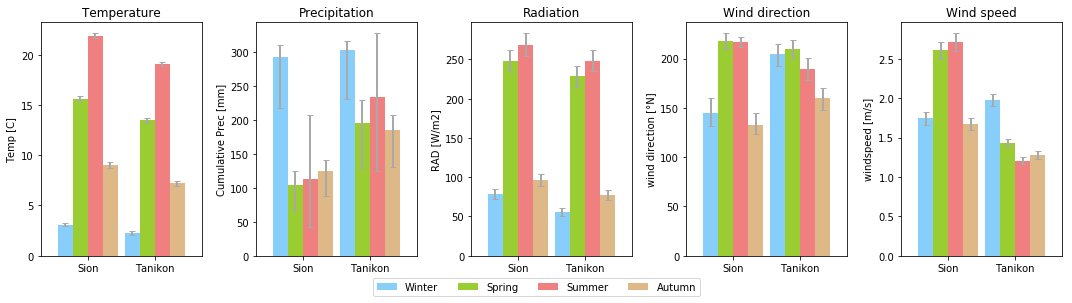

In [13]:
col = data_meteo_season.columns.to_list()
colors = ['lightskyblue','yellowgreen','lightcoral','burlywood']
barwidth = 0.9
titles = ['Temperature','Precipitation','Radiation','Wind direction', 'Wind speed']

fig1_2, axs = plt.subplots(1,5,figsize=(15,4))

for idx, ax in enumerate(axs.reshape(-1)):
    data_meteo_season[col[idx::5]].transpose().plot(kind='bar', ax = ax, color=colors, width=barwidth, \
                                                        yerr=np.array([data_meteo_season_inf[col[idx::5]].values, data_meteo_season_sup[col[idx::5]].values]).transpose([1,0,2]), \
                                                        error_kw=dict(elinewidth=2, ecolor='darkgray', capsize=3))
    if idx == 1:
        #data_meteo_season[col[idx::5]].transpose().plot(kind='bar', ax=ax, color=colors, width=barwidth)
        ax.set_ylabel('Cumulative ' + col[idx].replace(' SIO', ''))
    else:
        ax.set_ylabel(col[idx].replace(' SIO', ''))

    ax.set_title(titles[idx])
    ax.set_xticklabels(['Sion', 'Tanikon'])
    ax.xaxis.set_tick_params(rotation=0)
    ax.legend().set_visible(False)

handles, _ = axs[0].get_legend_handles_labels()
labels = ['Winter', 'Spring', 'Summer', 'Autumn']
lgd = fig1_2.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.06), bbox_transform=fig1_2.transFigure, ncol=4)

fig1_2.tight_layout()
#fig1_2.savefig('./Figures/'+'season2_avg.png', dpi=figure_res, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

### Monthly Evolution

The evolution of pollutants concentrations and meteorological parameters are studied over the year 2018 by month. All the quantities are grouped by month. The wind direction is reduced to the main 8<sup>th</sup> quadrant, namely N, NE, E, SE, S, SW, W and NW. 

In [14]:
pollutant_list = ['O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]']
meteo_list = ['Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'windspeed [m/s]','wind direction [°N]']

# group the data by month for both location and merge them
monthly_sion = data_sion[['Date']+pollutant_list+meteo_list]
monthly_sion_std = monthly_sion.groupby(monthly_sion.Date.dt.month).agg(std_dict)
monthly_sion = monthly_sion.groupby(monthly_sion.Date.dt.month).agg(mean_dict)
monthly_sion['wind direction [°N]'] = monthly_sion['wind direction [°N]'].apply(dirAngle2str)
monthly_sion = monthly_sion.reindex(columns=pollutant_list+meteo_list)

monthly_tanikon = data_tanikon[['Date']+pollutant_list+meteo_list]
monthly_tanikon_std = monthly_tanikon.groupby(monthly_tanikon.Date.dt.month).agg(std_dict)
monthly_tanikon = monthly_tanikon.groupby(monthly_tanikon.Date.dt.month).agg(mean_dict)
monthly_tanikon['wind direction [°N]'] = monthly_tanikon['wind direction [°N]'].apply(dirAngle2str)
monthly_tanikon = monthly_tanikon.reindex(columns=pollutant_list+meteo_list)

data_monthly = pd.merge(monthly_sion, monthly_tanikon, how='inner', right_index=True, left_index=True, suffixes=(' SIO', ' TAE'))
data_monthly_std = pd.merge(monthly_sion_std, monthly_tanikon_std, how='inner', right_index=True, left_index=True, suffixes=(' SIO', ' TAE'))

Then the time-series are ploted for each parameters and each location. The spreading around the means is represented by +/- the standard deviation. Note that the precipitation has no spreading representation as the cumulative precipitation over the month is presented. 

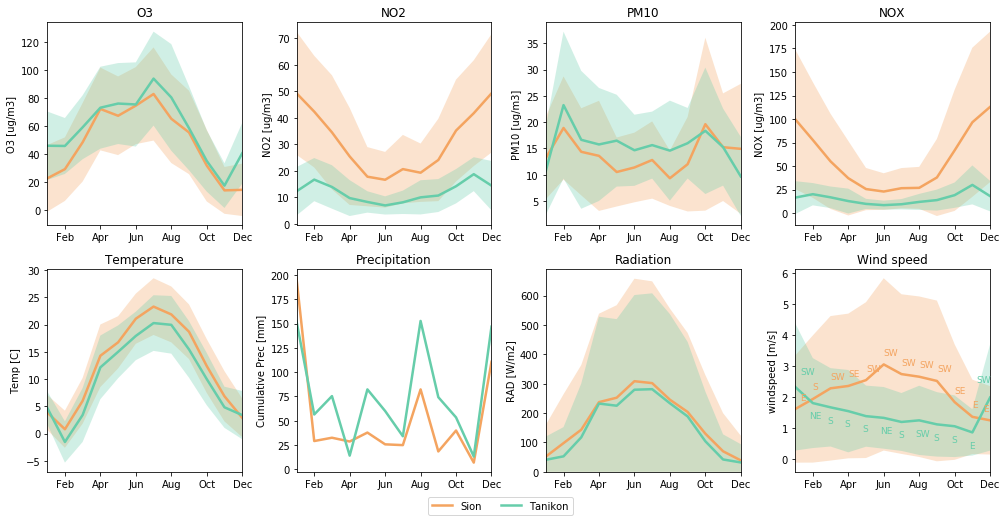

In [15]:
width = 2.5
col = data_monthly.columns.to_list()
colors = ['sandybrown','mediumaquamarine']
titles = ['O3','NO2','PM10','NOX','Temperature','Precipitation','Radiation','Wind speed']
ftsize = 9

fig2_1, axs = plt.subplots(2,4,figsize=(14,7))

for idx, ax in enumerate(axs.reshape(-1)):
    # Plot the time-series
    if not idx in [5,6]:
        ax.fill_between(data_monthly.index, data_monthly[col[idx]]+data_monthly_std[col[idx]], data_monthly[col[idx]]-data_monthly_std[col[idx]], facecolor=colors[0], alpha=0.3)
        ax.fill_between(data_monthly.index, data_monthly[col[idx+9]]+data_monthly_std[col[idx+9]], data_monthly[col[idx+9]]-data_monthly_std[col[idx+9]], facecolor=colors[1], alpha=0.3)
    elif idx == 6:
        ax.fill_between(data_monthly.index, data_monthly[col[idx]]+data_monthly_std[col[idx]], facecolor=colors[0], alpha=0.3)
        ax.fill_between(data_monthly.index, data_monthly[col[idx+9]]+data_monthly_std[col[idx+9]], facecolor=colors[1], alpha=0.3)

    data_monthly[col[idx::9]].plot(ax=ax, color=colors, linewidth=width)
    ax.set_title(titles[idx])
    ax.set_xlabel(None)
    
    # add the main wind direction to the wind speed plot 
    if idx == 7:
        for i, xy in enumerate(zip(data_monthly.index, data_monthly[col[idx]])):
            if i == 0:
                ax.annotate(data_monthly.loc[i+1,col[idx+1]], xy=xy, xytext=(xy[0]+0.3, xy[1]+0.3), color=colors[0], fontsize=ftsize)
            elif i == 11:
                ax.annotate(data_monthly.loc[i+1,col[idx+1]], xy=xy, xytext=(xy[0]-0.4, xy[1]+0.3), color=colors[0], fontsize=ftsize)
            else:
                ax.annotate(data_monthly.loc[i+1,col[idx+1]], xy=xy, xytext=(xy[0], xy[1]+0.3), color=colors[0], fontsize=ftsize)
                
        for i, xy in enumerate(zip(data_monthly.index, data_monthly[col[idx+9]])):
            if i == 0:
                ax.annotate(data_monthly.loc[i+1,col[idx+10]], xy=xy, xytext=(xy[0]+0.3, xy[1]+0.4), color=colors[1], fontsize=ftsize)
            elif i == 11:
                ax.annotate(data_monthly.loc[i+1,col[idx+10]], xy=xy, xytext=(xy[0]-0.8, xy[1]+0.5), color=colors[1], fontsize=ftsize)
            else:
                ax.annotate(data_monthly.loc[i+1,col[idx+10]], xy=xy, xytext=(xy[0]-0.2, xy[1]-0.5), color=colors[1], fontsize=ftsize)
    
    # some small adjustment on the labels
    if idx == 5:
        ax.set_ylabel('Cumulative ' + col[idx].replace(' SIO', ''))
    else:
        ax.set_ylabel(col[idx].replace(' SIO', ''))

    ax.set_xticklabels(['','Feb','Apr','Jun','Aug','Oct','Dec'])
    ax.legend().set_visible(False)

axs[1,2].set_ylim(bottom=0)
handles, _ = axs[0,0].get_legend_handles_labels()
labels = ['Sion', 'Tanikon']
lgd = fig2_1.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.04), bbox_transform=fig2_1.transFigure, ncol=2)

fig2_1.tight_layout()
#fig2_1.savefig('./Figures/'+'monthly_avg2.png', dpi=figure_res, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

### Precipitation and PM10 evolution

The precipitation is expected to lower PM10. In order to assess this phenomenon, the hourly time seires of PM10 and precipitation are plotted together. 

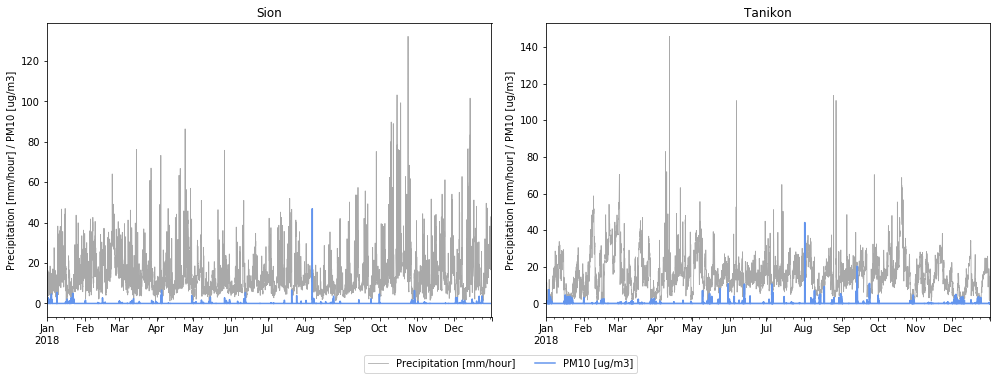

In [16]:
fig2_2, axs = plt.subplots(1,2,figsize=(14,5))

# SION 
data_sion.set_index('Date')[['PM10 [ug/m3]', 'Prec [mm]']].plot(ax=axs[0], color=['darkgray', 'cornflowerblue'])
axs[0].lines[0].set_linewidth(0.8)
axs[0].lines[1].set_linewidth(1.5)
axs[0].set_ylabel('Precipitation [mm/hour] / PM10 [ug/m3]')
axs[0].set_xlabel(None)
axs[0].set_title('Sion')
axs[0].legend().set_visible(False)

# TANIKON
data_tanikon.set_index('Date')[['PM10 [ug/m3]', 'Prec [mm]']].plot(ax=axs[1], color=['darkgray', 'cornflowerblue'])
axs[1].lines[0].set_linewidth(0.8)
axs[1].lines[1].set_linewidth(1.7)
axs[1].set_ylabel('Precipitation [mm/hour] / PM10 [ug/m3]')
axs[1].set_xlabel(None)
axs[1].set_title('Tanikon')
axs[1].legend().set_visible(False)

handles, _ = axs[0].get_legend_handles_labels()
labels = ['Precipitation [mm/hour]', 'PM10 [ug/m3]']
lgd = fig2_2.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.06), bbox_transform=fig2_2.transFigure, ncol=4)

fig2_2.tight_layout()
#fig2_2.savefig('./Figures/'+'Prec_vs_PM10.png', dpi=figure_res, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

### Spearman Correlation coefficients

To get insight into potential correlation between the polluants and meteorological parameters, the spearman correlation coefficients between all pair of parameters are computed. The Spearman correlation coefficient assess how well the two samples are mapped by a monotonic function (not necessary linear). Note that a good correlation does not imply a causation between the two factor. Moreover a high correlation can be obtained with no real link between the two samples (see the [Anscombe quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)) and a scatterplot should be plot to confirm the correlation relevance. 

All the coefficients are visualized through a heatmap. 

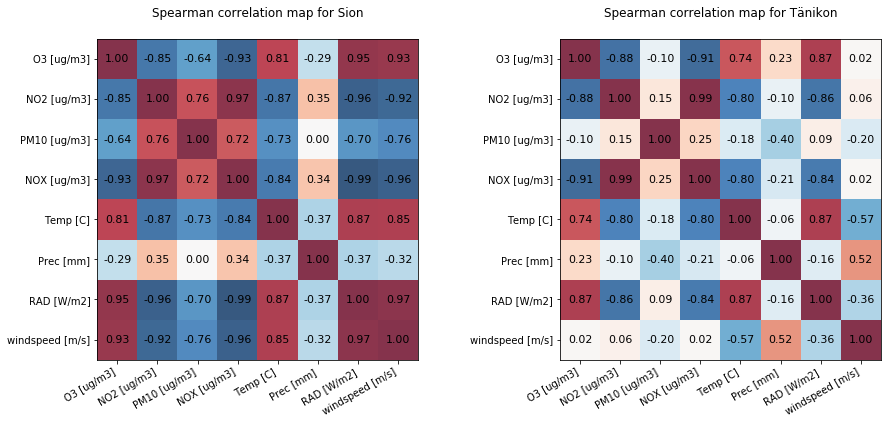

In [17]:
# Compute the correlation
corr = [monthly_sion.corr(method='spearman'), monthly_tanikon.corr(method='spearman')]
loc = ['Sion', 'Tänikon']

# Plot the heatmaps
fig2_3, axs = plt.subplots(1,2,figsize=(13, 6))

for idx, ax in enumerate(axs):
    ax.matshow(corr[idx], cmap='RdBu_r', alpha=0.8, vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr[idx].columns)))
    ax.set_yticks(range(len(corr[idx].columns)))
    ax.set_xticklabels(corr[idx].columns, rotation = 30, ha='right');
    ax.set_yticklabels(corr[idx].columns);
    ax.set_title('Spearman correlation map for '+loc[idx])
    ax.xaxis.tick_bottom()

    for (i, j), z in np.ndenumerate(corr[idx]):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=11)

fig2_3.tight_layout()
#fig2_3.savefig('./Figures/'+'monthly_corr.png', dpi=figure_res, bbox_inches='tight')
plt.show()

### Diurnal Evolution

To assess the effect of human's activities on the pollutants emission, the diurnal evolution is studied separately for week and week end days as it's a purely human-made distinction and the meteorological parameters should not change on average between Saturday and Wednesday. 

In [18]:
pollutant_list = ['O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]']
meteo_list = ['Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'windspeed [m/s]','wind direction [°N]']

# filter weekday and groupby Date.hour to get the hourly average of a weekday fro Sion
data_weekday_sion = data_sion[data_sion['Day type'] == 'weekday'].groupby(data_sion.Date.dt.hour).agg(mean_dict)
data_weekday_sion_std = data_sion[data_sion['Day type'] == 'weekday'].groupby(data_sion.Date.dt.hour).agg(std_dict)
data_weekday_sion['wind direction [°N]'] = data_weekday_sion['wind direction [°N]'].apply(dirAngle2str)
data_weekday_sion = data_weekday_sion.reindex(columns=pollutant_list+meteo_list)

# filter weekend and groupby Date.hour to get the hourly average of a weekend for Sion
data_weekend_sion = data_sion[data_sion['Day type'] == 'weekend'].groupby(data_sion.Date.dt.hour).agg(mean_dict)
data_weekend_sion_std = data_sion[data_sion['Day type'] == 'weekend'].groupby(data_sion.Date.dt.hour).agg(std_dict)
data_weekend_sion['wind direction [°N]'] = data_weekend_sion['wind direction [°N]'].apply(dirAngle2str)
data_weekend_sion = data_weekend_sion.reindex(columns=pollutant_list+meteo_list)

# merge the two temporaray dataframe
data_week_sion = pd.merge(data_weekday_sion, data_weekend_sion, how='inner', left_index=True, right_index=True, suffixes=(' weekday', ' weekend'))
data_week_sion_std = pd.merge(data_weekday_sion_std, data_weekend_sion_std, how='inner', left_index=True, right_index=True, suffixes=(' weekday', ' weekend'))

# filter weekday and groupby Date.hour to get the hourly average of a weekday for Tanikon
data_weekday_tanikon = data_tanikon[data_tanikon['Day type'] == 'weekday'].groupby(data_tanikon.Date.dt.hour).agg(mean_dict)
data_weekday_tanikon_std = data_tanikon[data_tanikon['Day type'] == 'weekday'].groupby(data_tanikon.Date.dt.hour).agg(std_dict)
data_weekday_tanikon['wind direction [°N]'] = data_weekday_tanikon['wind direction [°N]'].apply(dirAngle2str)
data_weekday_tanikon = data_weekday_tanikon.reindex(columns=pollutant_list+meteo_list)

# filter weekend and groupby Date.hour to get the hourly average of a weekend for Tanikon
data_weekend_tanikon = data_tanikon[data_sion['Day type'] == 'weekend'].groupby(data_tanikon.Date.dt.hour).agg(mean_dict)
data_weekend_tanikon_std = data_tanikon[data_sion['Day type'] == 'weekend'].groupby(data_tanikon.Date.dt.hour).agg(std_dict)
data_weekend_tanikon['wind direction [°N]'] = data_weekend_tanikon['wind direction [°N]'].apply(dirAngle2str)
data_weekend_tanikon = data_weekend_tanikon.reindex(columns=pollutant_list+meteo_list)

# merge the two temporaray dataframes
data_week_tanikon = pd.merge(data_weekday_tanikon, data_weekend_tanikon, how='inner', left_index=True, right_index=True, suffixes=(' weekday', ' weekend'))
data_week_tanikon_std = pd.merge(data_weekday_tanikon_std, data_weekend_tanikon_std, how='inner', left_index=True, right_index=True, suffixes=(' weekday', ' weekend'))

# get the final dataframe for plotting
data_week = pd.merge(data_week_sion, data_week_tanikon, how='inner', left_index=True, right_index=True, suffixes=(' SIO', ' TAE'))
data_week_std = pd.merge(data_week_sion_std, data_week_tanikon_std, how='inner', left_index=True, right_index=True, suffixes=(' SIO', ' TAE'))

Then the diurnal time-series are plotted :

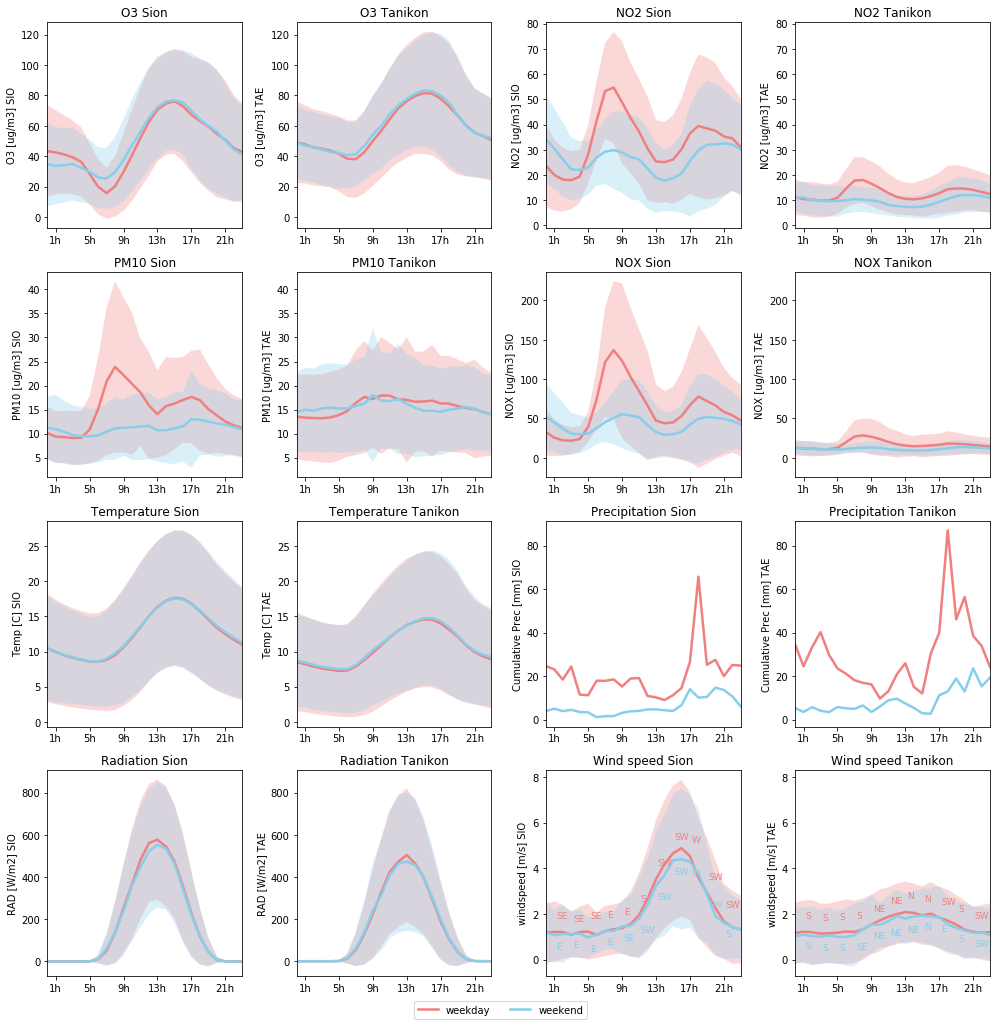

In [19]:
col = data_week.columns.to_list()
colors_2 = ['lightcoral','skyblue']
colors_text=['lightcoral', 'skyblue']
titles = ['O3 Sion','O3 Tanikon','NO2 Sion','NO2 Tanikon','PM10 Sion','PM10 Tanikon','NOX Sion','NOX Tanikon','Temperature Sion','Temperature Tanikon','Precipitation Sion','Precipitation Tanikon','Radiation Sion','Radiation Tanikon','Wind speed Sion','Wind speed Tanikon']
ftsize = 9

# reordonate columns name for easier plotting
col = [name for sublist in [col[i:18:9]+col[18+i:36:9] for i in range(9)] for name in sublist]

fig3_1, axs = plt.subplots(4,4,figsize=(14,14))

for idx, ax in enumerate(axs.reshape(-1)):
    if not idx in [10,11]:
        ax.fill_between(data_week.index, data_week[col[2*idx]]+data_week_std[col[2*idx]], data_week[col[2*idx]]-data_week_std[col[2*idx]], facecolor=colors_2[0], alpha=0.3)
        ax.fill_between(data_week.index, data_week[col[2*idx+1]]+data_week_std[col[2*idx+1]], data_week[col[2*idx+1]]-data_week_std[col[2*idx+1]], facecolor=colors_2[1], alpha=0.3)
        ax.set_ylabel(col[2*idx].replace(' weekday',''))
    else:
        ax.set_ylabel('Cumulative ' + col[2*idx].replace(' weekday',''))

    data_week[col[2*idx:2*idx+2]].plot(ax=ax, color=colors_2, linewidth=width)
    ax.set_title(titles[idx])
    ax.set_xlabel(None)
    ax.legend().set_visible(False)
    ax.set_xticks(np.arange(1,24,4))
    ax.set_xticklabels([str(i)+'h' for i in np.arange(1,24,4)])

    if idx in [14,15]:
        for i, xy in enumerate(zip(data_week.index, data_week[col[28+2*int(idx/15)]])):
            if i%2 != 0 and i%23 != 0:
                ax.annotate(data_week.loc[i,col[32+2*int(idx/15)]], xy=xy, xytext=(xy[0]+0.2, xy[1]+0.6), color=colors_text[0], fontsize=ftsize)

        for i, xy in enumerate(zip(data_week.index, data_week[col[28+2*int(idx/15)+1]])):
            if i%2 != 0 and i%23 != 0:
                ax.annotate(data_week.loc[i,col[32+2*int(idx/15)+1]], xy=xy, xytext=(xy[0]+0.2, xy[1]-0.6), color=colors_text[1], fontsize=ftsize)

for i in range(4):
    for j in range(0,3,2):
        axs[i,j].get_shared_y_axes().join(axs[i,j], axs[i,j+1])
        axs[i,j].autoscale(axis='y')

handles, labels = axs[0,0].get_legend_handles_labels()
labels = [lbl.replace('O3 [ug/m3] ','').replace(' SIO','') for lbl in labels]
lgd = fig3_1.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), bbox_transform=fig3_1.transFigure, ncol=2)

fig3_1.tight_layout()
#fig3_1.savefig('./Figures/'+'daily_avg.png', dpi=figure_res, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

### Exceedence of OPAIR legal limitation

Switzerland has some legal limits for some of the pollutants (yearly, hourly, daily). Those exceedance of those legal limit can be checked for the year 2018. 

In [20]:
# Legal limit in Switzerland for the pollutant measured in Sion and Tänikon
limits_annual = {'NO2':30,'PM10':20}
limits_daily = {'NO2':80,'PM10':50}
limits_hourly = {'O3':120}

# average on 24h periods
sion_24h_mean = data_sion[['Date', 'O3 [ug/m3]','NO2 [ug/m3]','PM10 [ug/m3]','NOX [ug/m3]', 'Temp [C]']].set_index('Date').rolling(window='24h').mean()
tanikon_24h_mean = data_tanikon[['Date', 'O3 [ug/m3]','NO2 [ug/m3]','PM10 [ug/m3]','NOX [ug/m3]']].set_index('Date').rolling(window='24h').mean()

# annual means
sion_annual_mean = data_sion[['O3 [ug/m3]','NO2 [ug/m3]','PM10 [ug/m3]','NOX [ug/m3]']].mean(axis=0)
tanikon_annual_mean = data_tanikon[['O3 [ug/m3]','NO2 [ug/m3]','PM10 [ug/m3]','NOX [ug/m3]']].mean(axis=0)

# Hourly mean is simply the data for the pollutant
sion_hourly_mean = data_sion[['Date','O3 [ug/m3]','NO2 [ug/m3]','PM10 [ug/m3]','NOX [ug/m3]']]
tanikon_hourly_mean = data_tanikon[['Date','O3 [ug/m3]','NO2 [ug/m3]','PM10 [ug/m3]','NOX [ug/m3]']]

In [21]:
# Check periods where limits are exceeded on the 24h averages : for NO2 and PM10
check_24h_limit(sion_24h_mean, limits_daily['PM10'], 'PM10', 'Sion')
check_24h_limit(sion_24h_mean, limits_daily['NO2'], 'NO2', 'Sion')
check_24h_limit(tanikon_24h_mean, limits_daily['PM10'], 'PM10', 'Tanikon')
check_24h_limit(tanikon_24h_mean, limits_daily['NO2'], 'NO2', 'Tanikon')

In Sion : 24h averages of PM10 has exceed the legal limit of 50 [ug/m3] during 0 periodes of times and for a total of 0 hours.
In Sion : 24h averages of NO2 has exceed the legal limit of 80 [ug/m3] during 1 periodes of times and for a total of 11 hours.
In Tanikon : 24h averages of PM10 has exceed the legal limit of 50 [ug/m3] during 2 periodes of times and for a total of 39 hours.
In Tanikon : 24h averages of NO2 has exceed the legal limit of 80 [ug/m3] during 0 periodes of times and for a total of 0 hours.


In [22]:
# Check if limits are exceeded on the annual averages : for NO2 and PM10
check_annual_limit(sion_annual_mean, limits_annual['PM10'], 'PM10', 'Sion')
check_annual_limit(sion_annual_mean, limits_annual['NO2'], 'NO2', 'Sion')
check_annual_limit(tanikon_annual_mean, limits_annual['PM10'], 'PM10', 'Tanikon')
check_annual_limit(tanikon_annual_mean, limits_annual['NO2'], 'NO2', 'Tanikon')

In Sion : the annual average of PM10 has NOT exceeded the legal limit of 20 [ug/m3], by 6.22 [ug/m3]
In Sion : the annual average of NO2 has exceeded the legal limit of 30 [ug/m3], by 1.30 [ug/m3]
In Tanikon : the annual average of PM10 has NOT exceeded the legal limit of 20 [ug/m3], by 4.46 [ug/m3]
In Tanikon : the annual average of NO2 has NOT exceeded the legal limit of 30 [ug/m3], by 18.03 [ug/m3]


In [23]:
# Check if the limits are exceed on the hourly averages for O3
periods_above_hourly = dict()
hour_above_hourly = dict()

check_hourly_limit(sion_hourly_mean, limits_hourly['O3'], 'O3', 'Sion', periods_above_hourly, hour_above_hourly)
check_hourly_limit(tanikon_hourly_mean, limits_hourly['O3'], 'O3', 'Tanikon', periods_above_hourly, hour_above_hourly)

In Sion : Hourly averages of O3 has exceed the legal limit of 120 [ug/m3] during 55 periodes of times and for a total of 193 hours.
In Tanikon : Hourly averages of O3 has exceed the legal limit of 120 [ug/m3] during 85 periodes of times and for a total of 489 hours.


In [24]:
# Store manually the number of period of exceedance for each polluatant
periods_above_daily = {'Sion_NO2':1,'Sion_PM10':0,'Tanikon_NO2':0,'Tanikon_PM10':2}
hour_above_daily = {'Sion_NO2':11,'Sion_PM10':0,'Tanikon_NO2':0,'Tanikon_PM10':39}

Visualize the exceedance

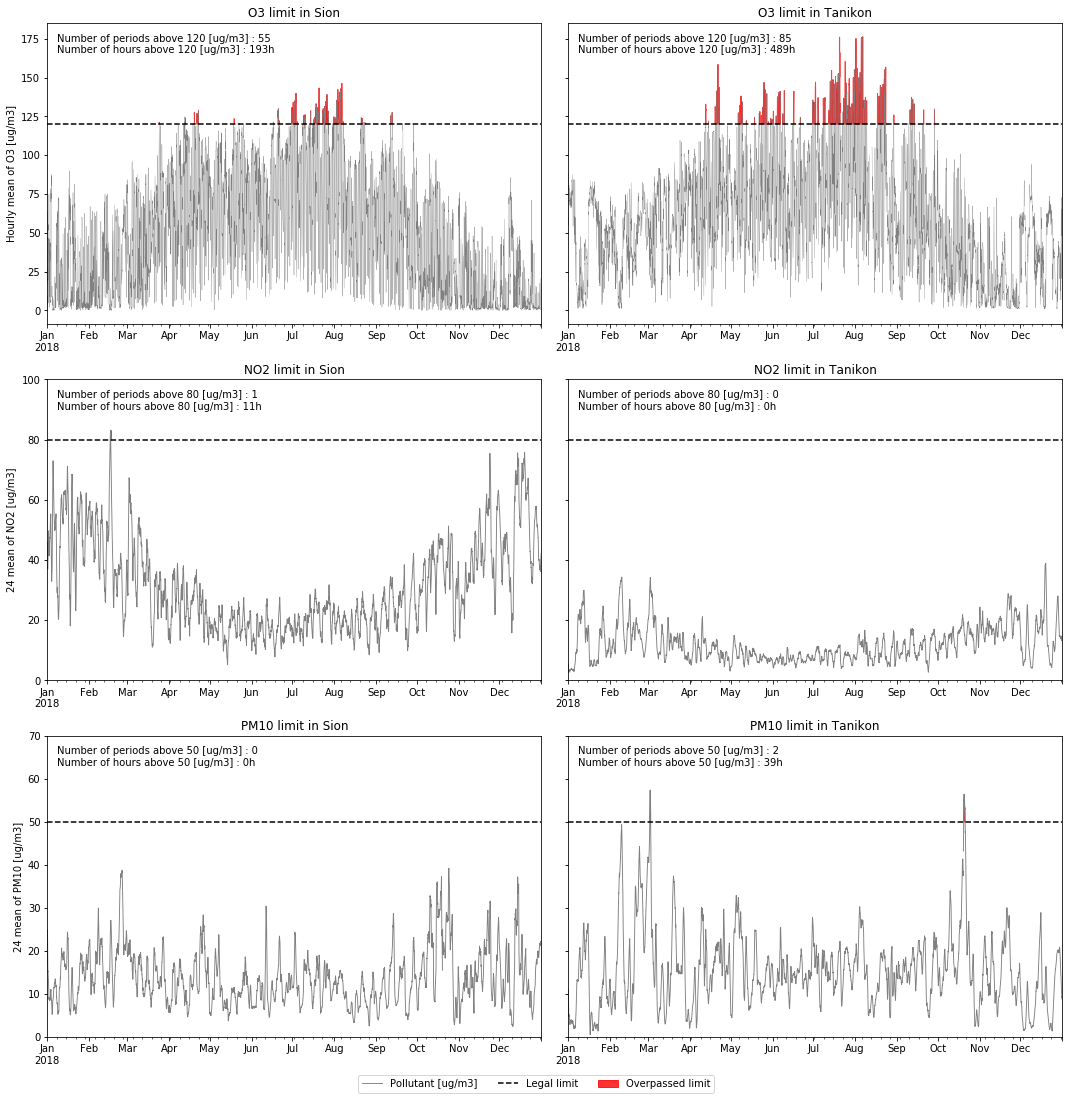

In [25]:
fig5_1, axs = plt.subplots(3,2,figsize=(15,15), sharey='row')

# Hourly exceedance of O3
df = [sion_hourly_mean.set_index('Date'), tanikon_hourly_mean.set_index('Date')]
titles = ['O3 limit in Sion', 'O3 limit in Tanikon']
keys = ['Sion_O3','Tanikon_O3']

for idx, ax in enumerate(axs[0,:]):
    df[idx].loc[:,'O3 [ug/m3]'].plot(ax=ax, color='gray', linewidth=.3)
    ax.axhline(y=limits_hourly['O3'], linestyle='--', color='black', linewidth=1.5, label='Legal limit')
    ax.fill_between(df[idx].index, df[idx].loc[:,'O3 [ug/m3]'], limits_hourly['O3'], where=(df[idx].loc[:,'O3 [ug/m3]'])>=limits_hourly['O3'], color='red', alpha=0.8, label='Overpassed limit')
    ax.set_title(titles[idx])
    ax.set_xlabel(None)
    ax.set_ylabel('Hourly mean of O3 [ug/m3]')

    ax.text(0.02,0.9,'Number of periods above {0} [ug/m3] : {1} \nNumber of hours above {0} [ug/m3] : {2}h'.format(limits_hourly['O3'], periods_above_hourly[keys[idx]],hour_above_hourly[keys[idx]]), transform=ax.transAxes)

# daily exceedance of NO2
df = [sion_24h_mean, tanikon_24h_mean]
titles = ['NO2 limit in Sion', 'NO2 limit in Tanikon']
keys = ['Sion_NO2','Tanikon_NO2']

for idx, ax in enumerate(axs[1,:]):
    df[idx].loc[:,'NO2 [ug/m3]'].plot(ax=ax, color='gray', linewidth=.9)
    ax.axhline(y=limits_daily['NO2'], linestyle='--', color='black', linewidth=1.5, label='Legal limit')
    ax.fill_between(df[idx].index, df[idx].loc[:,'NO2 [ug/m3]'], limits_daily['NO2'], where=(df[idx].loc[:,'NO2 [ug/m3]'])>=limits_daily['NO2'], color='red', alpha=0.8, label='Overpassed limit')
    ax.set_title(titles[idx])
    ax.set_xlabel(None)
    ax.set_ylabel('24 mean of NO2 [ug/m3]')

    ax.text(0.02,0.9,'Number of periods above {0} [ug/m3] : {1} \nNumber of hours above {0} [ug/m3] : {2}h'.format(limits_daily['NO2'], periods_above_daily[keys[idx]],hour_above_daily[keys[idx]]), transform=ax.transAxes)
axs[1,0].set_ylim(0,100)

# daily exceedance of PM10
df = [sion_24h_mean, tanikon_24h_mean]
titles = ['PM10 limit in Sion', 'PM10 limit in Tanikon']
keys = ['Sion_PM10','Tanikon_PM10']

for idx, ax in enumerate(axs[2,:]):
    df[idx].loc[:,'PM10 [ug/m3]'].plot(ax=ax, color='gray', linewidth=.9)
    ax.axhline(y=limits_daily['PM10'], linestyle='--', color='black', linewidth=1.5, label='Legal limit')
    ax.fill_between(df[idx].index, df[idx].loc[:,'PM10 [ug/m3]'], limits_daily['PM10'], where=(df[idx].loc[:,'PM10 [ug/m3]'])>=limits_daily['PM10'], color='red', alpha=0.8, label='Overpassed limit')
    ax.set_title(titles[idx])
    ax.set_xlabel(None)
    ax.set_ylabel('24 mean of PM10 [ug/m3]')

    ax.text(0.02,0.9,'Number of periods above {0} [ug/m3] : {1} \nNumber of hours above {0} [ug/m3] : {2}h'.format(limits_daily['PM10'], periods_above_daily[keys[idx]],hour_above_daily[keys[idx]]), transform=ax.transAxes)
axs[2,0].set_ylim(0,70)

handles, labels = axs[2,0].get_legend_handles_labels()
labels[0] = 'Pollutant [ug/m3]'
lgd = fig5_1.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), bbox_transform=fig5_1.transFigure, ncol=3)

fig5_1.tight_layout()
#fig5_1.savefig('./Figures/'+'limit.png', dpi=figure_res, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Inferential Analysis
The present section focues on statistically analyse the differences/similarities between pollutants concentration/meteorological parameters

### Weekend vs Weekday difference

To statistically assess whether there exists a difference between the mean pollutants concentrations during week-end and week-days : 
1. The difference is assessed graphically by visualizing the 95% confidence intervals
2. A Mann-Whitney-U test is performed to compare the mean (as the distributions seems to be non-normal and likely dependant)
3. the whole distributions weekend and weekday are tested for similarities using a Kolmogorov-Smirnov test

In [26]:
# extract subdataframe of weekend and weekday values
data_weekend = pd.merge(data_sion.loc[data_sion['Day type'] == 'weekend', ['Date', 'O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]']], \
                        data_tanikon.loc[data_tanikon['Day type'] == 'weekend', ['Date', 'O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]']], \
                        how='inner', right_on='Date', left_on='Date', suffixes=(' SIO', ' TAE')).drop(columns={'Date'})

data_weekday = pd.merge(data_sion.loc[data_sion['Day type'] == 'weekday', ['Date', 'O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]']], \
                        data_tanikon.loc[data_tanikon['Day type'] == 'weekday', ['Date', 'O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]']], \
                        how='inner', right_on='Date', left_on='Date', suffixes=(' SIO', ' TAE')).drop(columns={'Date'})

**1** Graphically observe 95% confidence intervals

In [27]:
# Conpute the confidence intervals
confint_weekend = conf_int_bootstrap(data_weekend)
confint_weekend

,O3 [ug/m3] SIO,NO2 [ug/m3] SIO,PM10 [ug/m3] SIO,NOX [ug/m3] SIO,O3 [ug/m3] TAE,NO2 [ug/m3] TAE,PM10 [ug/m3] TAE,NOX [ug/m3] TAE
0.025,47.449340,25.889346,10.823439,40.862276,57.906248,9.559498,15.072713,11.264596
0.975,50.344192,27.347255,11.378901,44.115906,60.641343,10.046120,15.841420,11.899821


In [28]:
confint_weekday = conf_int_bootstrap(data_weekday)
confint_weekday

,O3 [ug/m3] SIO,NO2 [ug/m3] SIO,PM10 [ug/m3] SIO,NOX [ug/m3] SIO,O3 [ug/m3] TAE,NO2 [ug/m3] TAE,PM10 [ug/m3] TAE,NOX [ug/m3] TAE
0.025,46.893484,32.585789,14.560698,61.003985,56.901035,12.617276,15.306560,16.763511
0.975,48.780481,33.757427,15.135062,64.531867,58.738893,13.041039,15.841085,17.541453


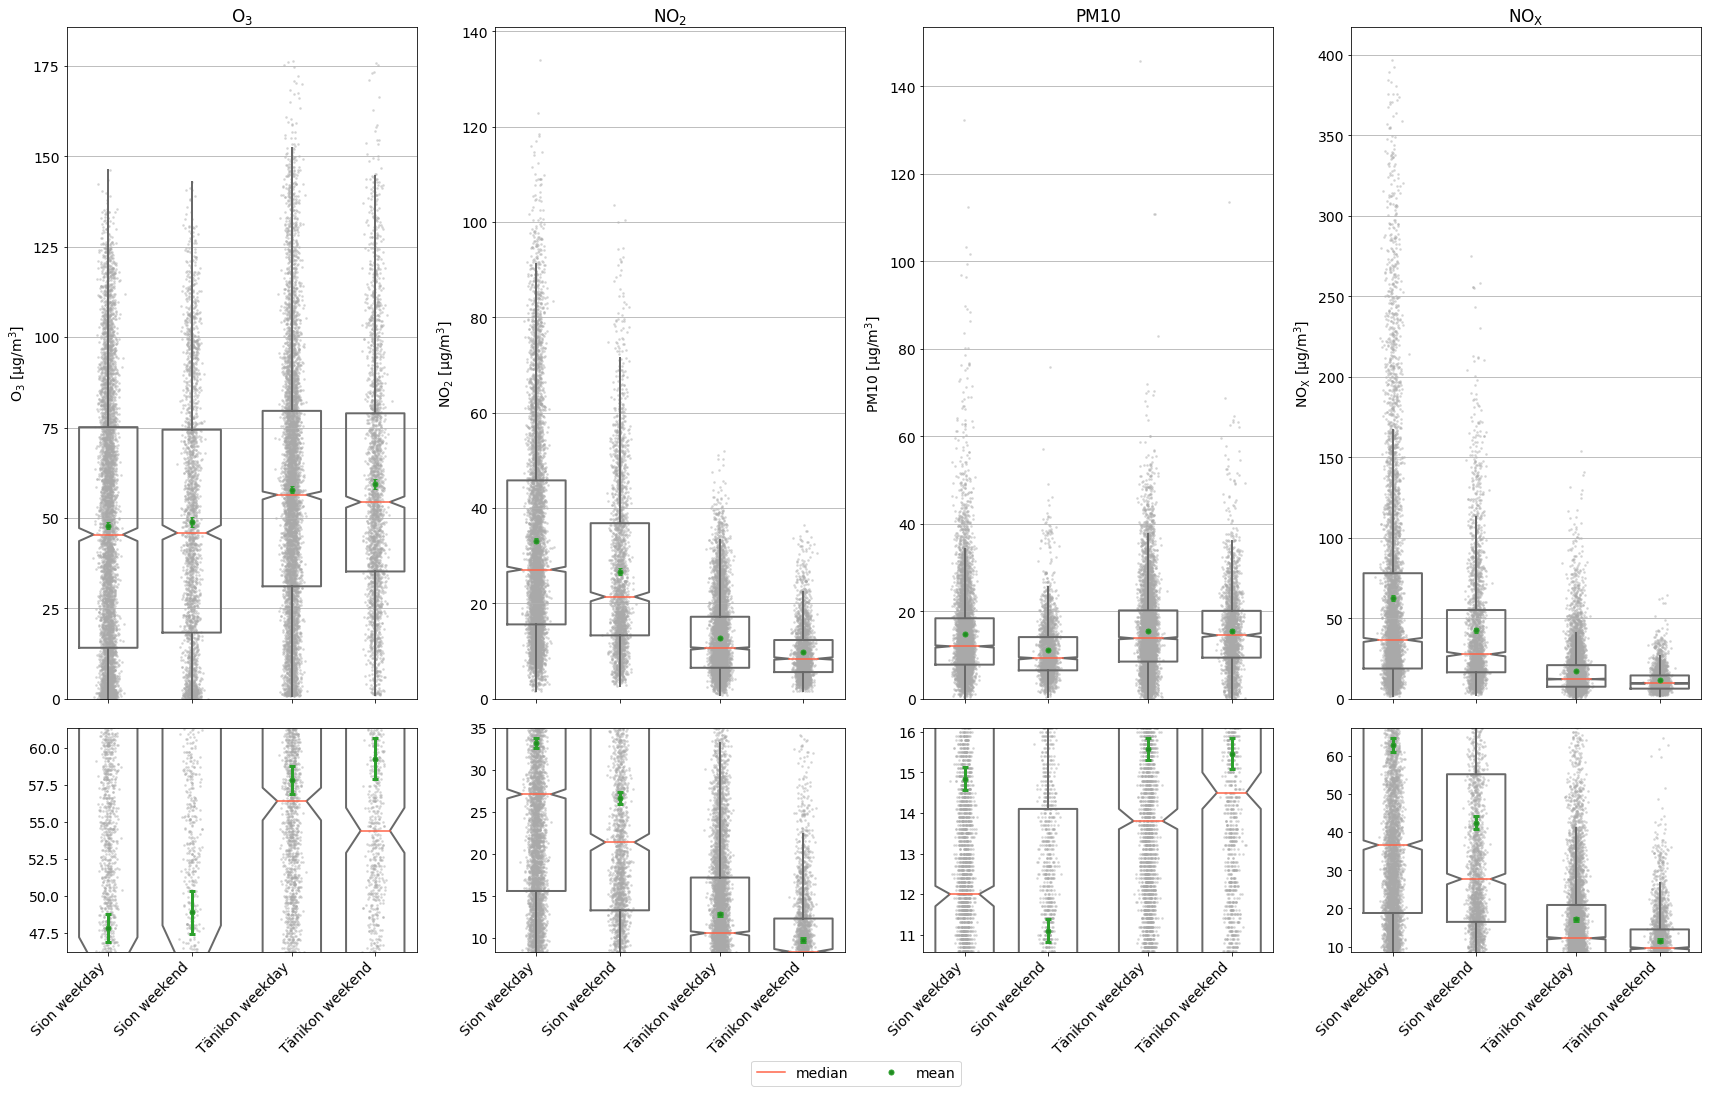

In [29]:
# Boxplot for each pollutant
boxdict = dict(linestyle='-', linewidth=2, color='dimgray')
whiskerdict = dict(linestyle='-', linewidth=2, color='dimgray')
mediandict = dict(linestyle='-', linewidth=1.5, color='tomato')
meandict = dict(marker='o' ,markerfacecolor='forestgreen', markeredgecolor=None, markersize=5, linewidth=0)

tickslabels = ['Sion weekday', 'Sion weekend', 'Tänikon weekday', 'Tänikon weekend']
titles = ['$\mathregular{O_3}$','$\mathregular{NO_2}$','PM10','$\mathregular{NO_X}$']
ylab = ['$\mathregular{O_3 \ [\mu g/m^3]}$','$\mathregular{NO_2 \ [\mu g/m^3]}$','$\mathregular{PM10 \ [\mu g/m^3]}$','$\mathregular{NO_X \ [\mu g/m^3]}$']
dot_size = 25
pos = [1,2,3.2,4.2]

plt.rcParams.update({'font.size': 14})

fig6_1, axs = plt.subplots(nrows=2,ncols=4,figsize=(24,15), gridspec_kw={'height_ratios':[3,1]})

for idx, (ax1, ax2) in enumerate(zip(axs[0,:].reshape(-1), axs[1,:].reshape(-1))):
    values = [data_weekday.iloc[:,idx].dropna(), data_weekend.iloc[:,idx].dropna(), data_weekday.iloc[:,idx+4].dropna(), data_weekend.iloc[:,idx+4].dropna()]
    lower = [confint_weekday.iloc[0,idx], confint_weekend.iloc[0,idx], confint_weekday.iloc[0,idx+4], confint_weekend.iloc[0,idx+4]]
    upper = [confint_weekday.iloc[1,idx], confint_weekend.iloc[1,idx], confint_weekday.iloc[1,idx+4], confint_weekend.iloc[1,idx+4]]
    means = [val.mean(axis=0) for val in values]
    err_means_lower = [m-l for m,l in zip(means, lower)]
    err_means_upper = [u-m for m,u in zip(means, upper)]

    ax1.boxplot(values, \
                positions=pos, notch=True, bootstrap=5000, \
                widths = 0.7, showfliers=False, showcaps=False, showmeans=False, boxprops=boxdict, whiskerprops=whiskerdict, medianprops=mediandict, meanprops=meandict)
    ax2.boxplot(values, \
                positions=pos, notch=True, bootstrap=5000, \
                widths = 0.7, showfliers=False, showcaps=False, showmeans=False, boxprops=boxdict, whiskerprops=whiskerdict, medianprops=mediandict, meanprops=meandict)
    ax1.errorbar(pos, means, yerr=[err_means_lower, err_means_upper], elinewidth=2.2, capsize=2, **meandict)
    ax2.errorbar(pos, means, yerr=[err_means_lower, err_means_upper], elinewidth=3, capsize=3, capthick=3, **meandict)

    for k in range(len(values)):
        ax1.scatter(np.random.normal(pos[k], 0.05, values[k].shape[0]), values[k], c='darkgray', alpha=0.5, marker='.', s=dot_size, lw = 0)
        ax2.scatter(np.random.normal(pos[k], 0.05, values[k].shape[0]), values[k], c='darkgray', alpha=0.5, marker='.', s=dot_size, lw = 0)

    ax2.set_xticklabels(tickslabels, rotation=45, ha="right")
    ax1.set_xticklabels(4*[None])
    ax1.grid(True, 'both', 'y')
    ax1.set_title(titles[idx])
    ax1.set_ylabel(ylab[idx])
    ax1.set_ylim(bottom=0)
    #d = max([m+e for m,e in zip(means, err_means_upper)])-min([m-e for m,e in zip(means, err_means_lower)])
    d = max(upper)-min(lower)
    ax2.set_ylim([min(lower)-0.05*d, max(upper)+0.05*d])

handles = [plt.Line2D((0,1),(0,0), **mediandict), plt.Line2D((0,1),(0,0), **meandict)]
labels = ['median','mean']
lgd = fig6_1.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), bbox_transform=fig6_1.transFigure, ncol=2)

fig6_1.tight_layout()
#fig6_1.savefig('./Figures/'+'boxplots_pollutants.png', dpi=figure_res, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

**2 & 3** Statistical test to compare the means and the distributions

In [30]:
index_names = ['O3', 'NO2', 'PM10', 'NOX']
cols = ['O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]']

pval_df_pollutant = comparisonTests(data_weekday, data_weekend, index_names, cols, 'mannwhitneyu')
pval_df_pollutant_dist = comparisonTests(data_weekday, data_weekend, index_names, cols, 'kolmogorovsmirnov')

Repeat the same procedure with the meteorological parameters

In [31]:
data_weekend = pd.merge(data_sion.loc[data_sion['Day type'] == 'weekend', ['Date', 'Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'wind direction [°N]', 'windspeed [m/s]']], \
                        data_tanikon.loc[data_tanikon['Day type'] == 'weekend', ['Date', 'Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'wind direction [°N]', 'windspeed [m/s]']], \
                        how='inner', right_on='Date', left_on='Date', suffixes=(' SIO', ' TAE')).drop(columns={'Date'})

data_weekday = pd.merge(data_sion.loc[data_sion['Day type'] == 'weekday', ['Date', 'Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'wind direction [°N]', 'windspeed [m/s]']], \
                        data_tanikon.loc[data_tanikon['Day type'] == 'weekday', ['Date', 'Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'wind direction [°N]', 'windspeed [m/s]']], \
                        how='inner', right_on='Date', left_on='Date', suffixes=(' SIO', ' TAE')).drop(columns={'Date'})

**1** Graphically observe 95% confidence intervals

In [32]:
# define how to compute the mean for each columns for the bootstrap
mean_dict_meteo_week = {'Temp [C] SIO':'mean', \
                   'Prec [mm] SIO':'mean', \
                   'RAD [W/m2] SIO':'mean', \
                   'wind direction [°N] SIO':mean_direction, \
                   'windspeed [m/s] SIO':'mean', \
                  'Temp [C] TAE':'mean', \
                   'Prec [mm] TAE':'mean', \
                   'RAD [W/m2] TAE':'mean', \
                   'wind direction [°N] TAE':mean_direction, \
                   'windspeed [m/s] TAE':'mean'}

In [33]:
confint_weekend = conf_int_bootstrap(data_weekend, N=1000, agg_dict=mean_dict_meteo_week)
confint_weekend

,Temp [C] SIO,Prec [mm] SIO,RAD [W/m2] SIO,wind direction [°N] SIO,windspeed [m/s] SIO,Temp [C] TAE,Prec [mm] TAE,RAD [W/m2] TAE,wind direction [°N] TAE,windspeed [m/s] TAE
0.025,12.186173,0.045185,158.097772,167.711883,2.008727,10.373904,0.065982,141.641011,147.533302,1.334787
0.975,12.925848,0.070931,180.524103,193.622418,2.184642,11.047037,0.098935,162.734465,179.272568,1.440165


In [34]:
confint_weekday = conf_int_bootstrap(data_weekday, N=1000, agg_dict=mean_dict_meteo_week)
confint_weekday

,Temp [C] SIO,Prec [mm] SIO,RAD [W/m2] SIO,wind direction [°N] SIO,windspeed [m/s] SIO,Temp [C] TAE,Prec [mm] TAE,RAD [W/m2] TAE,wind direction [°N] TAE,windspeed [m/s] TAE
0.025,12.195631,0.062964,168.269922,186.238372,2.164100,10.257183,0.094287,146.692990,191.108133,1.468157
0.975,12.683876,0.098926,183.236467,200.311060,2.284623,10.724823,0.137516,160.490856,202.297643,1.538276


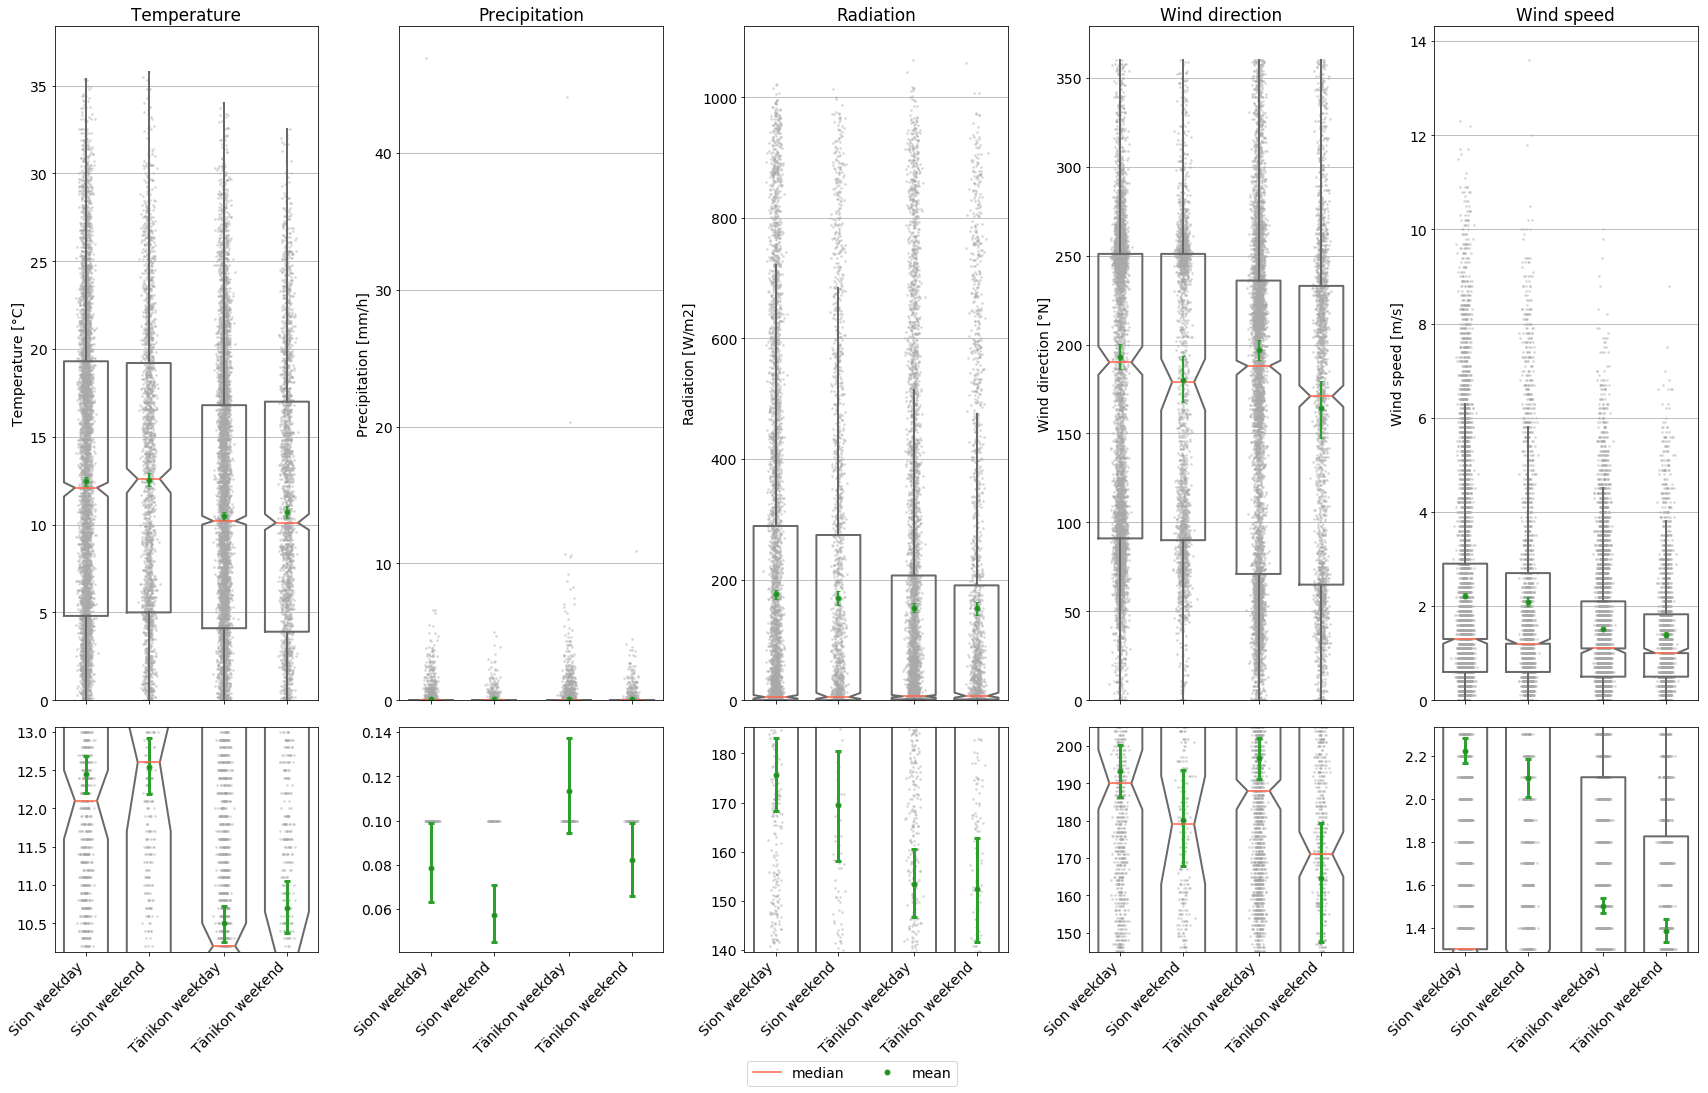

In [35]:
# Boxplot for each meteorological parameters
boxdict = dict(linestyle='-', linewidth=2, color='dimgray')
whiskerdict = dict(linestyle='-', linewidth=2, color='dimgray')
mediandict = dict(linestyle='-', linewidth=1.5, color='tomato')
meandict = dict(marker='o' ,markerfacecolor='forestgreen', markeredgecolor=None, markersize=5, linewidth=0)

tickslabels = ['Sion weekday', 'Sion weekend', 'Tänikon weekday', 'Tänikon weekend']
titles = ['Temperature','Precipitation','Radiation','Wind direction', 'Wind speed']
ylab = ['Temperature [°C]','Precipitation [mm/h]','Radiation $\mathregular{[W/m2]}$','Wind direction [°N]', 'Wind speed [m/s]']
dot_size = 25
pos = [1,2,3.2,4.2]

fig6_2, axs = plt.subplots(2,5,figsize=(24,15), gridspec_kw={'height_ratios':[3,1]})

for idx, (ax1, ax2) in enumerate(zip(axs[0,:].reshape(-1), axs[1,:].reshape(-1))):
    values = [data_weekday.iloc[:,idx].dropna(), data_weekend.iloc[:,idx].dropna(), data_weekday.iloc[:,idx+5].dropna(), data_weekend.iloc[:,idx+5].dropna()]
    lower = [confint_weekday.iloc[0,idx], confint_weekend.iloc[0,idx], confint_weekday.iloc[0,idx+5], confint_weekend.iloc[0,idx+5]]
    upper = [confint_weekday.iloc[1,idx], confint_weekend.iloc[1,idx], confint_weekday.iloc[1,idx+5], confint_weekend.iloc[1,idx+5]]
    if idx==3:
        means = [mean_direction(val) for val in values]
    else:
        means = [val.mean(axis=0) for val in values]
    err_means_lower = [m-l for m,l in zip(means, lower)]
    err_means_upper = [u-m for m,u in zip(means, upper)]

    ax1.boxplot(values, \
                positions=pos, notch=True, bootstrap=5000, \
                widths = 0.7, showfliers=False, showcaps=False, showmeans=False, boxprops=boxdict, whiskerprops=whiskerdict, medianprops=mediandict, meanprops=meandict)
    ax2.boxplot(values, \
                positions=pos, notch=True, bootstrap=5000, \
                widths = 0.7, showfliers=False, showcaps=False, showmeans=False, boxprops=boxdict, whiskerprops=whiskerdict, medianprops=mediandict, meanprops=meandict)
    ax1.errorbar(pos, means, yerr=[err_means_lower, err_means_upper], elinewidth=2.2, capsize=2, **meandict)
    ax2.errorbar(pos, means, yerr=[err_means_lower, err_means_upper], elinewidth=3, capsize=3, capthick=3, **meandict)

    for k in range(len(values)):
        ax1.scatter(np.random.normal(pos[k], 0.05, values[k].shape[0]), values[k], c='darkgray', alpha=0.5, marker='.', s=dot_size, lw = 0)
        ax2.scatter(np.random.normal(pos[k], 0.05, values[k].shape[0]), values[k], c='darkgray', alpha=0.5, marker='.', s=dot_size, lw = 0)

    ax2.set_xticklabels(tickslabels, rotation=45, ha="right")
    ax1.set_xticklabels(4*[None])
    ax1.grid(True, 'both', 'y')
    ax1.set_title(titles[idx])
    ax1.set_ylabel(ylab[idx])
    ax1.set_ylim(bottom=0)
    d = max(upper)-min(lower)
    ax2.set_ylim([min(lower)-0.05*d, max(upper)+0.05*d])

handles = [plt.Line2D((0,1),(0,0), **mediandict), plt.Line2D((0,1),(0,0), **meandict)]
labels = ['median','mean']
lgd = fig6_2.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), bbox_transform=fig6_2.transFigure, ncol=2)

fig6_2.tight_layout()
#fig6_2.savefig('./Figures/'+'boxplots_meteo.png', dpi=figure_res, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

**2 & 3** Statistical test to compare the means and the distributions

In [36]:
index_names = ['Temperature', 'Precipitation', 'Radiation', 'Wind direction', 'Wind speed']
cols = ['Temp [C]', 'Prec [mm]', 'RAD [W/m2]', 'wind direction [°N]', 'windspeed [m/s]']

pval_df_meteo = comparisonTests(data_weekday, data_weekend, index_names, cols, 'mannwhitneyu')
pval_df_meteo_dist = comparisonTests(data_weekday, data_weekend, index_names, cols, 'kolmogorovsmirnov')

merge the two p_val dataframes and save it in csv

In [53]:
# for Mann-Whithney-U test
pval_df = pval_df_pollutant.append(pval_df_meteo).astype(float)
pd.set_option('display.float_format', '{:.3g}'.format)
pval_df
#pval_df.to_csv('data_output/mannwhitneyu_pval.csv', sep=',', encoding='utf-8', float_format='%.3g')

,SIO weekday vs SIO weekend,SIO weekday vs TAE weekday,SIO weekday vs TAE weekend,SIO weekend vs TAE weekday,SIO weekend vs TAE weekend,TAE weekday vs TAE weekend
O3,0.143,5.22e-59,8.21e-45,9.12e-31,5.18e-29,0.108
NO2,1.21e-33,0,0,7.85e-310,0,1.04e-51
PM10,3.13e-58,3.96e-15,1.57e-12,1.94e-101,3.9e-84,0.29
NOX,4.28e-32,0,0,7.94e-310,0,2.07e-55
Temperature,0.414,2.24e-29,3.02e-15,9.96e-19,5.86e-12,0.239
Precipitation,0.348,5.22e-07,0.000108,3.73e-05,0.00043,0.459
Radiation,0.346,5.46e-83,3.49e-50,9.23e-50,2.9e-36,0.419
Wind direction,0.0963,6.59e-21,4.84e-27,4.2e-09,8.64e-16,0.000269
Wind speed,0.0543,8.6e-43,2.36e-37,1.31e-18,4.07e-21,0.00371


In [54]:
# for kolmogorov-smirnov test
pval_df_dist = pval_df_pollutant_dist.append(pval_df_meteo_dist).astype(float)
pd.set_option('display.float_format', '{:.3g}'.format)
pval_df_dist
#pval_df_dist.to_csv('data_output/ks_pval.csv', sep=',', encoding='utf-8', float_format='%.3g')

,SIO weekday vs SIO weekend,SIO weekday vs TAE weekday,SIO weekday vs TAE weekend,SIO weekend vs TAE weekday,SIO weekend vs TAE weekend,TAE weekday vs TAE weekend
O3,0.0121,1.28e-59,1.71e-64,2.2e-24,1.14e-32,2.35e-06
NO2,1.4e-22,0,0,4.37e-207,1.03e-305,1.05e-43
PM10,1.62e-42,3.76e-28,2.37e-26,2.8e-100,7.64e-84,0.0324
NOX,4.24e-23,0,0,2.43e-240,0,2.03e-42
Temperature,0.327,2.6e-31,1.18e-16,8.03e-17,3.35e-11,0.193
Precipitation,1,0.0425,0.232,0.143,0.326,1
Radiation,0.722,0,2.42e-321,3.04e-313,3.89e-226,0.605
Wind direction,0.137,2.26e-78,1.68e-53,1.18e-38,1.6e-32,1.2e-05
Wind speed,0.125,1.05e-47,2.76e-33,1.48e-18,1e-16,0.000232


### Correlation and Lagged Correlation

Compute the correlation without lag 

In [38]:
c1, l1 = crossCorr(data_sion.drop(columns={'Season', 'Day type', 'Date', 'wind direction [°N]'}), padding=(0,0))
c3, l3 = crossCorr(data_tanikon.drop(columns={'Season', 'Day type', 'Date', 'wind direction [°N]'}), padding=(0,0))

Compute the correlation with the best lag over the range +12h / -12h

In [39]:
c2, l2 = crossCorr(data_sion.drop(columns={'Season', 'Day type', 'Date', 'wind direction [°N]'}), padding=(12,12))
c4, l4 = crossCorr(data_tanikon.drop(columns={'Season', 'Day type', 'Date', 'wind direction [°N]'}), padding=(12,12))

Plot the heat-maps

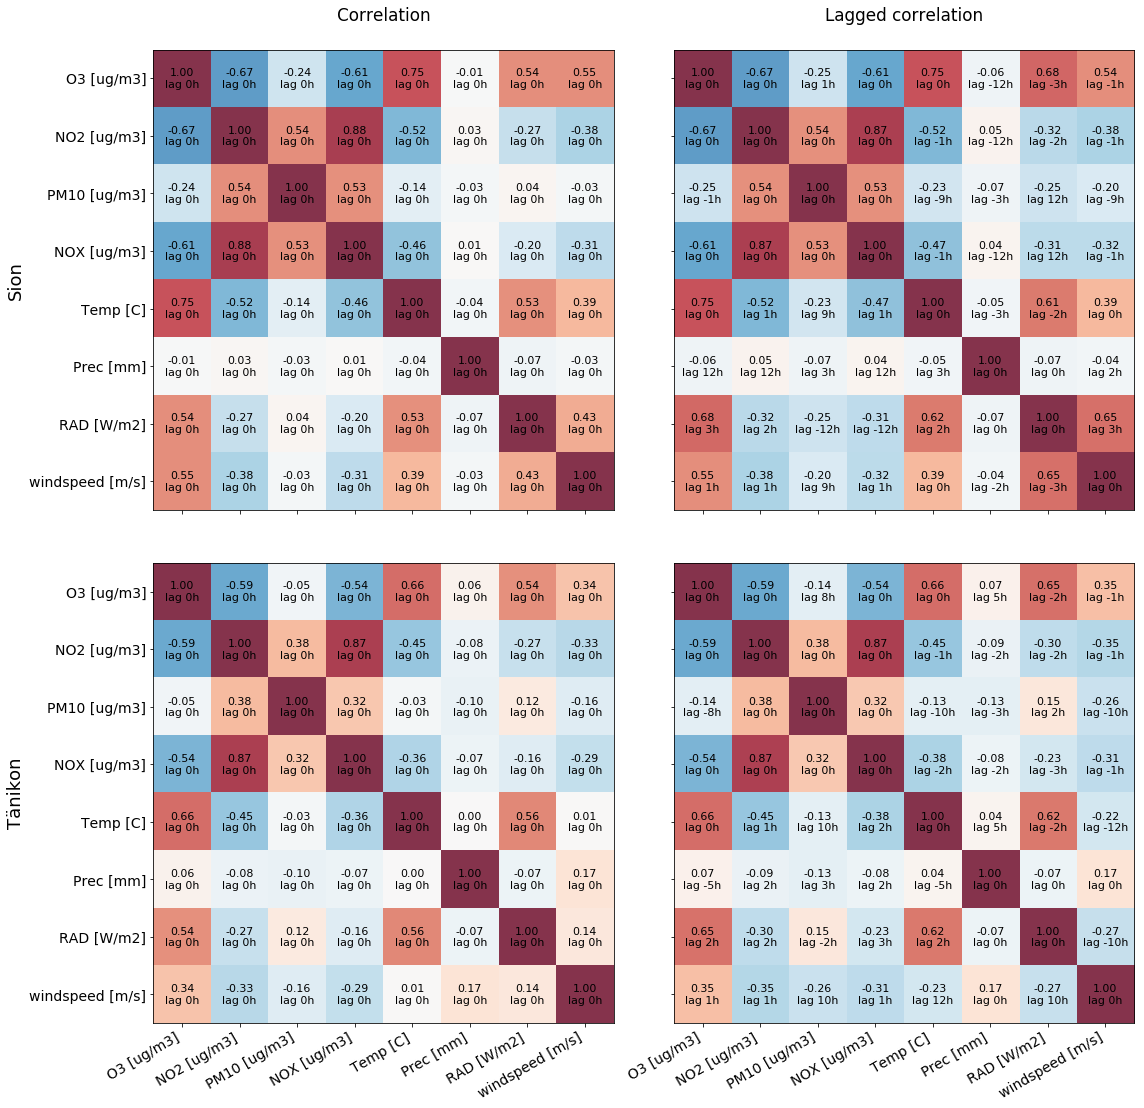

In [40]:
corr = [c1,c2,c3,c4]
lag = [l1,l2,l3,l4]
titles = ['Correlation', 'Lagged correlation']
labels = ['Sion', '', 'Tänikon']

fig7_1, axs = plt.subplots(2,2,figsize=(16,16))

for idx, ax in enumerate(axs.reshape(-1)):
    ax.matshow(corr[idx], cmap='RdBu_r', alpha=0.8, vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr[idx].columns)))
    ax.set_yticks(range(len(corr[idx].columns)))

    if idx in [2,3]:
        ax.set_xticklabels(corr[idx].columns, rotation = 30, ha='right')
    else:
        ax.set_xticklabels([None]*8)
        ax.set_title(titles[idx])
    if idx in [0,2]:
        ax.set_yticklabels(corr[idx].columns)
        ax.set_ylabel(labels[idx], fontsize=18)
    else:
        ax.set_yticklabels([None]*8)

    ax.xaxis.tick_bottom()

    for (i, j), z in np.ndenumerate(corr[idx]):
        ax.text(i, j, '{0:0.2f}\nlag {1}h'.format(z, int(lag[idx].iloc[i,j])), ha='center', va='center', fontsize=11)

fig7_1.tight_layout()
#fig7_1.savefig('./Figures/yearly_correlations.png', dpi=figure_res)
plt.show()

In order to assess the link between two variables, the correlation coefficient should be coupled with a scatter plot. Here the scatter plots are split in four sub-scatterplot, one for each season; the correlation coefficient by season is presented as a barplot. However to avoid having hundreds of plots, only the correlation impying O<sub>3</sub> or NO<sub>2</sub> are made 

/Users/antoine/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


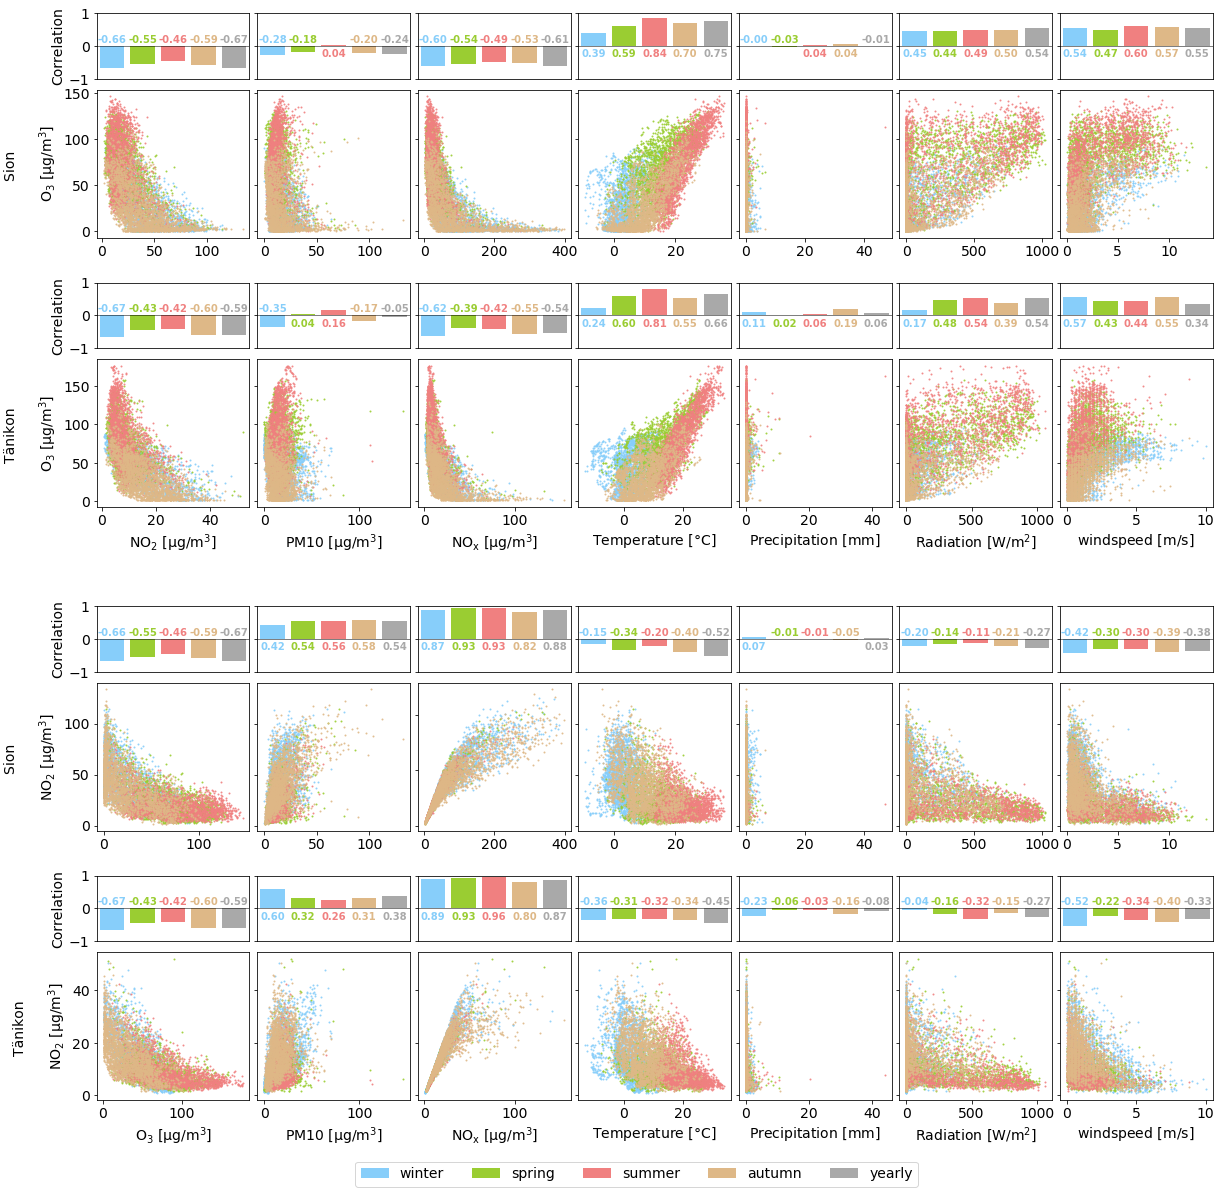

In [41]:
seasons = ['winter', 'spring', 'summer', 'autumn']
# get the correlation by seasons 
corr_sion = [crossCorr(data_sion[data_sion['Season']==season].drop(columns={'Season', 'Day type', 'Date', 'wind direction [°N]'}), padding=(0,0))[0] for season in seasons]
corr_sion.append(crossCorr(data_sion.drop(columns={'Season', 'Day type', 'Date', 'wind direction [°N]'}), padding=(0,0))[0])
corr_tanikon = [crossCorr(data_tanikon[data_tanikon['Season']==season].drop(columns={'Season', 'Day type', 'Date', 'wind direction [°N]'}), padding=(0,0))[0] for season in seasons]
corr_tanikon.append(crossCorr(data_tanikon.drop(columns={'Season', 'Day type', 'Date', 'wind direction [°N]'}), padding=(0,0))[0])

corr = [corr_sion, corr_tanikon]
data = [data_sion, data_tanikon]

# plotting parameters definition
colors = ['lightskyblue','yellowgreen','lightcoral','burlywood']
prop_dict = dict(linewidth=0, marker='o', markersize=2, markeredgewidth=0.0, alpha=0.9)
pollutant = ['O3 [ug/m3]','NO2 [ug/m3]']
cols = [data_sion.columns.drop(['Season', 'Date', 'Day type', 'wind direction [°N]', 'O3 [ug/m3]']), \
        data_sion.columns.drop(['Season', 'Date', 'Day type', 'wind direction [°N]', 'NO2 [ug/m3]'])]
xlabels = [['$\mathregular{NO_2 \ [\mu g/m^3]}$', '$\mathregular{PM10 \ [\mu g/m^3]}$', '$\mathregular{NO_x \ [\mu g/m^3]}$', '$\mathregular{Temperature \ [\degree C]}$', '$\mathregular{Precipitation \ [mm]}$', '$\mathregular{Radiation \ [W/m^2]}$', '$\mathregular{wind speed \ [m/s]}$'],\
           ['$\mathregular{O_3 \ [\mu g/m^3]}$', '$\mathregular{PM10 \ [\mu g/m^3]}$', '$\mathregular{NO_x \ [\mu g/m^3]}$', '$\mathregular{Temperature \ [\degree C]}$', '$\mathregular{Precipitation \ [mm]}$', '$\mathregular{Radiation \ [W/m^2]}$', '$\mathregular{wind speed \ [m/s]}$']]
ylabels = [['Sion \n\n$\mathregular{O_3 \ [\mu g/m^3]}$', 'Tänikon \n\n$\mathregular{O_3 \ [\mu g/m^3]}$'], \
           ['Sion \n\n$\mathregular{NO_2 \ [\mu g/m^3]}$', 'Tänikon \n\n$\mathregular{NO_2 \ [\mu g/m^3]}$']]

# Make the plot
fig = plt.figure(figsize=(20, 20))

outer_big = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.2)
for p in range(outer_big._nrows):
    outer = gridspec.GridSpecFromSubplotSpec(2, 7, subplot_spec=outer_big[p], wspace=0.05, hspace=0.2)
    for r in range(outer._nrows):
        for c in range(outer._ncols):
            inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[r*7+c], hspace=0.1, height_ratios=[4,9])

            ax1 = plt.Subplot(fig, inner[0])
            ax2 = plt.Subplot(fig, inner[1])
            
            # plot the correlation barplot
            ax1.bar([i for i in range(len(corr[r]))], [corr[r][j].loc[pollutant[p],cols[p][c]] for j in range(len(corr[r]))], color=colors+['darkgray'])
            for j in range(len(corr[r])):
                val = corr[r][j].loc[pollutant[p],cols[p][c]]
                pos=(j,-0.25)
                if val <= 0 :
                    pos = (j,0.2)
                ax1.annotate(str('{:2.2f}'.format(val)), pos, color=(colors+['darkgray'])[j], fontsize=10, fontweight='bold', ha='center', va='center', transform=ax1.transAxes)

            ax1.plot([-1,5], [0,0], linewidth=0.5, linestyle='-', color='black')
            ax1.set_ylim([-1,1])
            ax1.set_xlim([-0.5,4.5])
            ax1.get_xaxis().set_visible(False)
    
            # plot the scatterplot for each season 
            for season, color in zip(seasons, colors):
                ax2.plot(data[r].loc[data[r]['Season']==season, cols[p][c]], data[r].loc[data[r]['Season']==season, pollutant[p]], markerfacecolor=color, **prop_dict)
            
            # put axis label only where needed
            if c!=0 :
                ax1.set_yticklabels([])
                ax2.set_yticklabels([])
            else:
                ax1.set_ylabel('Correlation')
                ax2.set_ylabel(ylabels[p][r])

            if r%2!=0: ax2.set_xlabel(xlabels[p][c])

            fig.add_subplot(ax1)
            fig.add_subplot(ax2)

# make the legend 
handles = [mpatch.Patch(facecolor=c) for c in colors+['darkgray']]
labels = seasons+['yearly']
lgd = fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.06), bbox_transform=fig.transFigure, ncol=5)

#fig.savefig('./Figures/'+'scatter_hist_O3_NO2.png', dpi=figure_res, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.show()

### Analysis of Sources on the month of July

get the data for the month of July and only the pollutant's concentrations

In [42]:
sion_july_hourly = data_sion.loc[data_sion['Date'].dt.month==7, ['Date', 'O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]']].set_index('Date')
tanikon_july_hourly = data_tanikon.loc[data_tanikon['Date'].dt.month==7, ['Date', 'O3 [ug/m3]', 'NO2 [ug/m3]', 'PM10 [ug/m3]', 'NOX [ug/m3]']].set_index('Date')

Take the daily average of it

In [43]:
sion_july_daily = sion_july_hourly.groupby(sion_july_hourly.index.day).mean()
tanikon_july_daily = tanikon_july_hourly.groupby(tanikon_july_hourly.index.day).mean()

To test for lognormal distribution, fisrt the log is taken and then it is tested for normality. There are two possible test for normality : Shapiro-Wilk or D'Agostino-Pearson K<sup>2</sup> test. The Shapiro-Wilk test is suited for small size samples (roughly less than 50) while the D'Agostino-Pearson K<sup>2</sup> is suited for larger samples. The daily averaged samples for july contains 31 samples and the hourly averaged contains 744 (24*31) samples. Therefore the tests are not suited for daily and hourly averaged, that's why both test are performed. 

In [44]:
# Apply the log-transformation
sion_july_hourly = sion_july_hourly.apply(np.log).dropna()
tanikon_july_hourly = tanikon_july_hourly.apply(np.log).dropna()
sion_july_daily = sion_july_daily.apply(np.log).dropna()
tanikon_july_daily = tanikon_july_daily.apply(np.log).dropna()

In [45]:
# Shapiro test
test = 'shapiro'

s1 = testNormality(sion_july_hourly, test=test)
s2 = testNormality(tanikon_july_hourly, test=test)
s3 = testNormality(sion_july_daily, test=test)
s4 = testNormality(tanikon_july_daily, test=test)

col = pd.MultiIndex.from_product([['hourly', 'daily'],['Sion', 'Tänikon']])
idx = ['O3','NO2','PM10','NOX']

pvals_df = pd.concat([s1,s2,s3,s4], axis=1)
pvals_df.columns = col
pvals_df.index = idx
pd.set_option('display.float_format', '{:.3g}'.format)
pvals_df

#pvals_df.to_csv('data_output/'+test+'_pval.csv', sep=',', encoding='utf-8', float_format='%.3g')

hourly           daily        
         Sion  Tänikon   Sion Tänikon
O3   5.38e-24 1.77e-15 0.0745   0.086
NO2    0.0701 5.19e-05 0.0229  0.0785
PM10 2.56e-05 1.87e-08  0.219  0.0038
NOX  0.000487 5.99e-06 0.0229   0.206

In [46]:
# D'Agostino-Pearson k2 test 
test = 'normaltest'

s1 = testNormality(sion_july_hourly, test=test)
s2 = testNormality(tanikon_july_hourly, test=test)
s3 = testNormality(sion_july_daily, test=test)
s4 = testNormality(tanikon_july_daily, test=test)

col = pd.MultiIndex.from_product([['hourly', 'daily'],['Sion', 'Tänikon']])
idx = ['O3','NO2','PM10','NOX']

pvals_df = pd.concat([s1,s2,s3,s4], axis=1)
pvals_df.columns = col
pvals_df.index = idx
pd.set_option('display.float_format', '{:.3g}'.format)
pvals_df

#pvals_df.to_csv('data_output/'+test+'_pval.csv', sep=',', encoding='utf-8', float_format='%.3g')

hourly          daily        
         Sion  Tänikon  Sion Tänikon
O3   5.49e-34  1.2e-19 0.196   0.158
NO2     0.441 1.36e-06 0.134   0.208
PM10 0.000534 7.65e-11 0.452  0.0513
NOX   0.00551 6.88e-05 0.156   0.307

To better visualize how the close/far from normality the test outcome is, QQ-plots are made 

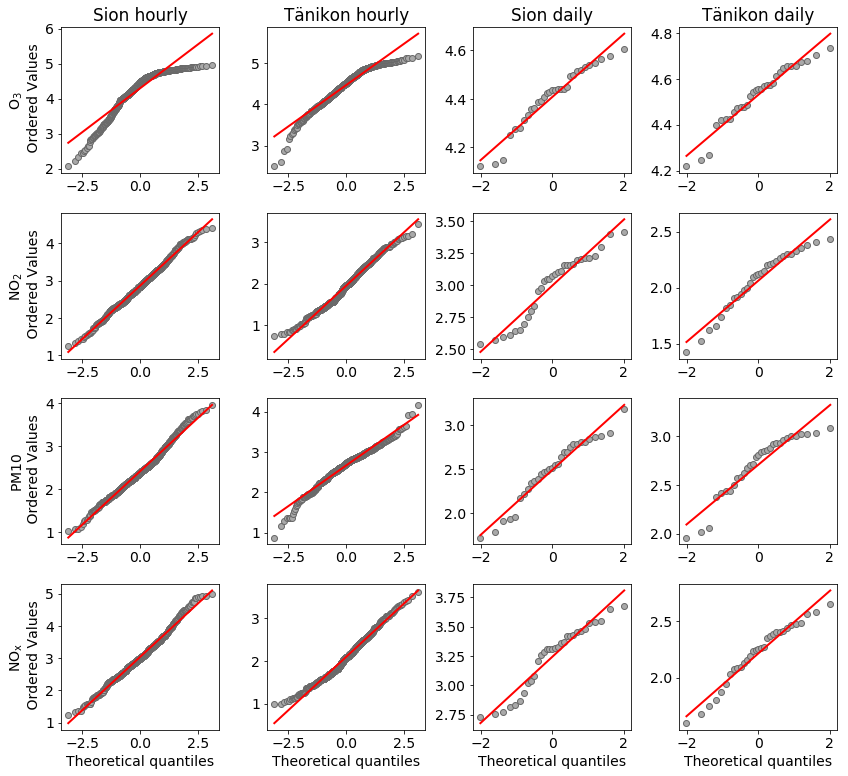

In [47]:
titles = ['Sion hourly', 'Tänikon hourly', 'Sion daily', 'Tänikon daily']
ylables = ['$\mathregular{O_3}$ \n Ordered Values', '$\mathregular{NO_2}$ \n Ordered Values', '$\mathregular{PM10}$ \n Ordered Values', '$\mathregular{NO_x}$ \n Ordered Values']

fig8_1, axs = plt.subplots(4,4, figsize=(12,11))

for idx2, (data, title) in enumerate(zip([sion_july_hourly, tanikon_july_hourly, sion_july_daily, tanikon_july_daily], titles)):
    for idx1, (c, ylabel) in enumerate(zip(list(sion_july_daily.columns), ylables)):
        res = stats.probplot(data[c], dist='norm', plot=axs[idx1,idx2]) #, sparams=(2.5,)
        axs[idx1,idx2].get_lines()[0].set_marker('o')
        axs[idx1,idx2].get_lines()[0].set_markerfacecolor('darkgray')
        axs[idx1,idx2].get_lines()[0].set_markeredgecolor('dimgray')
        axs[idx1,idx2].get_lines()[0].set_markersize(6.0)
        axs[idx1,idx2].get_lines()[1].set_linewidth(2.0)
        axs[idx1,idx2].get_lines()[1].set_color('red')

        if idx1 != 3:
            axs[idx1,idx2].set_xlabel(None)

        if idx2 != 0:
            axs[idx1,idx2].set_ylabel(None)
        else:
            axs[idx1,idx2].set_ylabel(ylabel)

        if idx1 == 0:
            axs[idx1,idx2].set_title(title)
        else:
            axs[idx1,idx2].set_title(None)

fig8_1.tight_layout()
#fig8_1.savefig('./Figures/'+'QQplots.png', dpi=figure_res)
plt.show()

### Unusual Pattern

To investigate unusual pattern, the first step performed in this analysis is to plot the time-series of the pollutants and meteorological parameters for both location (left = Sion ; right = Tänikon). 

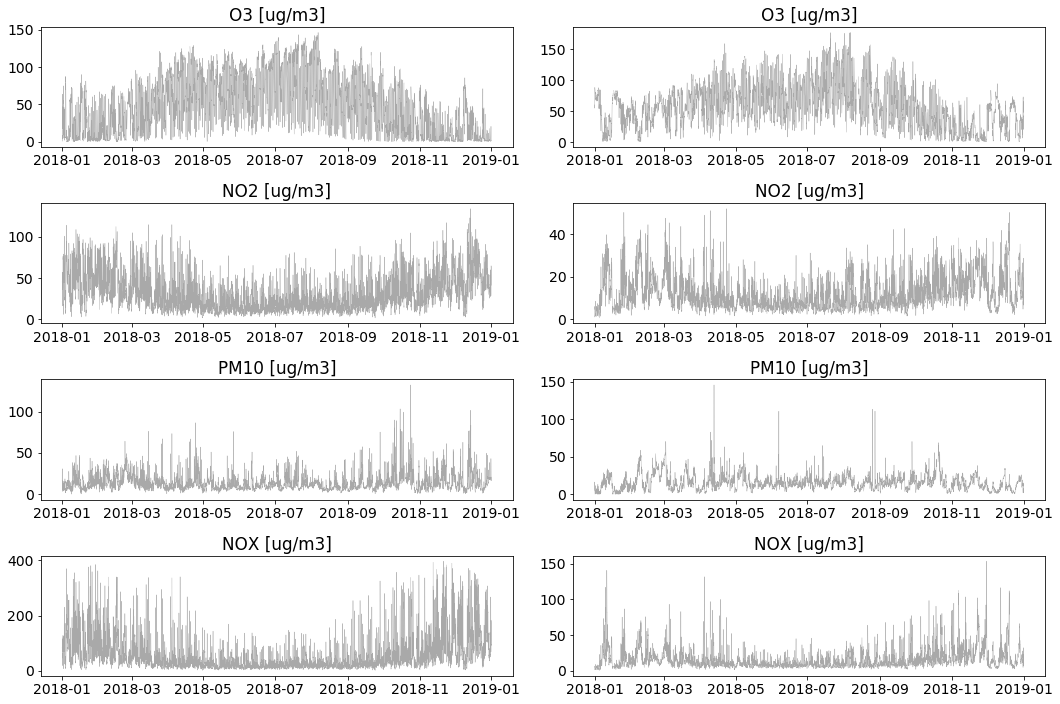

In [48]:
# Pollutants
fig, axs = plt.subplots(4,2,figsize=(15, 10))
cols = data_sion.columns

for idx, ax in enumerate(np.reshape(axs[:,0],-1)):
    ax.plot(data_sion.loc[:,'Date'], data_sion.loc[:,cols[idx+1]], linewidth=.4, color='darkgray', marker=None)
    ax.set_title(cols[idx+1])

for idx, ax in enumerate(np.reshape(axs[:,1],-1)):
    ax.plot(data_tanikon.loc[:,'Date'], data_tanikon.loc[:,cols[idx+1]], linewidth=.4, color='darkgray', marker=None)
    ax.set_title(cols[idx+1])

fig.tight_layout()
plt.show()

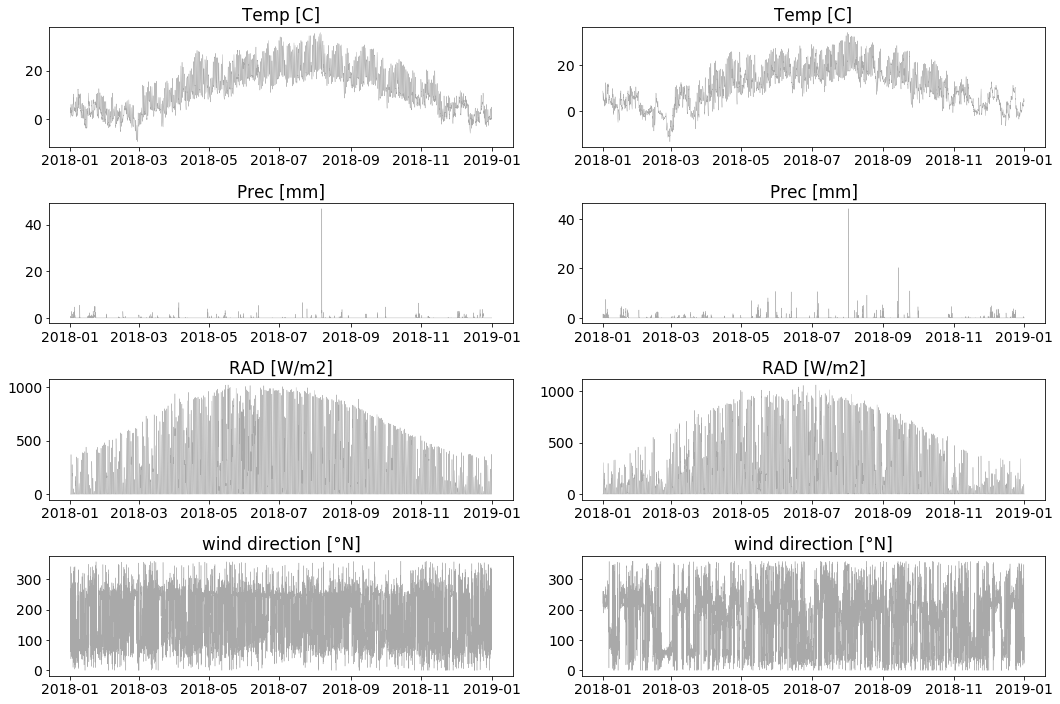

In [49]:
 # Meteo
fig, axs = plt.subplots(4,2,figsize=(15,10))
cols = data_tanikon.columns

for idx, ax in enumerate(np.reshape(axs[:,0],-1)):
    ax.plot(data_sion.loc[:,'Date'], data_sion.loc[:,cols[idx+5]], linewidth=.4, color='darkgray', marker=None)
    ax.set_title(cols[idx+5])

for idx, ax in enumerate(np.reshape(axs[:,1],-1)):
    ax.plot(data_tanikon.loc[:,'Date'], data_tanikon.loc[:,cols[idx+5]], linewidth=.4, color='darkgray', marker=None)
    ax.set_title(cols[idx+5])
fig.tight_layout()
plt.show()

It looks like that PM10 is rather high in Tänikon around the end of February and the begining of March. We first look when the daily average overpass 40 [ug/m<sup>3</sup>]. 

In [50]:
data_tanikon_daily = data_tanikon.groupby([data_tanikon.Date.dt.month, data_tanikon.Date.dt.day]).agg(mean_dict)
dates = data_tanikon_daily[data_tanikon_daily['PM10 [ug/m3]'] > 40]
dates

O3 [ug/m3]  NO2 [ug/m3]  PM10 [ug/m3]  NOX [ug/m3]  Temp [C]  \
Date Date                                                                 
2    8           13.2           33          44.8         41.4    -0.663   
     9           14.6         29.9          42.5         41.8    -0.121   
     22          57.6         16.2          40.4         17.9     -2.69   
     28          54.1         19.9          41.7         24.4     -8.33   
3    1           51.6           26          44.1         31.8     -6.22   
     2           44.5         31.4          49.9         35.9      -4.9   
10   20          30.2         15.2          53.4         18.9      10.9   

           Prec [mm]  RAD [W/m2]  wind direction [°N]  windspeed [m/s]  
Date Date                                                               
2    8           0.9          39               0.0181            0.425  
     9             0        31.1                 45.1            0.608  
     22            0        10.8                 54.2             3.72  
     28            0         122                 68.3              2.2  
3    1             1        71.9                 70.1             1.87  
     2           1.5        65.4                  157             1.53  
10   20            0         108                 70.7            0.692

During this period is seems that the temperature is rather low. We thus test if the temperature is significatntly lower during the periode 19.02 - 04-03 than during the whole winter (H : m<sub>T period</sub> >= m<sub>T winter</sub> ; A : m<sub>T period</sub> < m<sub>T winter</sub>). We also test that PM10 is significantly higher during this period than on the whole data (H : m<sub>PM10 period</sub> <= m<sub>PM10 winter</sub> ; A : m<sub>PM10 period</sub> > m<sub>PM10 winter</sub>). 
<br>
The means are compared by a Mann-Whitney-U test

In [51]:
data_high = data_tanikon.loc[(data_tanikon['Date']>=dt.datetime(2018,2,19,0)) & (data_tanikon['Date']<dt.datetime(2018,3,4,0)),['PM10 [ug/m3]','Temp [C]']]
_ , p_val_PM10 = stats.mannwhitneyu(data_tanikon.loc[data_tanikon['Season']=='winter','PM10 [ug/m3]'], data_high['PM10 [ug/m3]'], alternative='less') # H : mean(PM10_all) = mean(PM10_period) A: mean(PM10_all) < mean(PM10_period)
_ , p_val_T = stats.mannwhitneyu(data_tanikon.loc[data_tanikon['Season']=='winter','Temp [C]'], data_high['Temp [C]'], alternative='greater') # H : mean(Temp_all) = mean(Temp_period) A: mean(Temp_all) > mean(Temp_period)
print('H : mean(PM10_all) = mean(PM10_period) \nA: mean(PM10_all) < mean(PM10_period) \n >>> p-value = {0:.3E}'.format(p_val_PM10))
print('H : mean(Temp_all) = mean(Temp_period) \nA: mean(Temp_all) > mean(Temp_period) \n >>> p-value = {0:.3E}'.format(p_val_T))

H : mean(PM10_all) = mean(PM10_period) 
A: mean(PM10_all) < mean(PM10_period) 
 >>> p-value = 6.206E-83
H : mean(Temp_all) = mean(Temp_period) 
A: mean(Temp_all) > mean(Temp_period) 
 >>> p-value = 3.387E-101


It seems that a lowering in temperature is correlated with an increase in PM10. A summary plot is made and contains : 
1. the diurnal evolution of the days with a daily concentration above 40 [ug/m<sup>3</sup>] to check if it's not due to any ouliers
2. a scatter plot Temperature vs PM10 with a linear fitting curve and the R<sup>2</sup> value (during the period 17.02 - 09.03)
3. The time-series of Temperature, PM10 and precipitation during the periods 17.02 - 09.03 

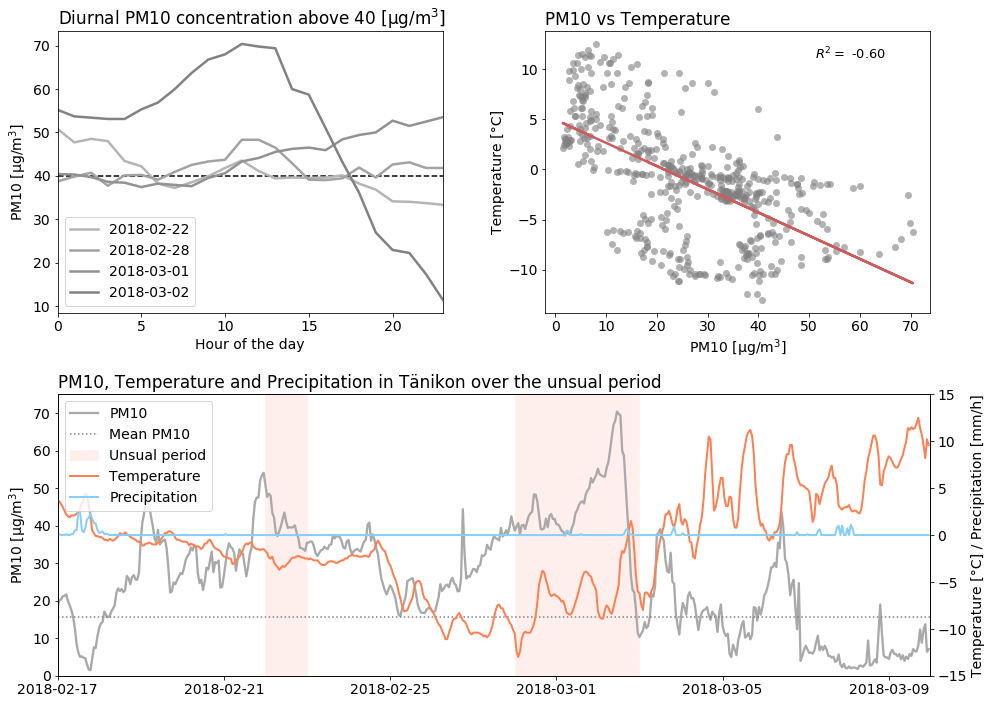

In [52]:
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

# diurnal plot
cmap = cm.get_cmap('Greys')
color_idx = [0.4+i/(2.5*len(dates)) for i in range(len(dates))]

ax1.plot([0,23],[40,40],linewidth=1.5, linestyle='--', color='black')
dates = [dt.datetime(2018, date[0], date[1]) for date in dates.index]
dates = dates[2:6] # keep only the relevant dates (the period feb-mar)
for date, color_idx in zip(dates, color_idx):
    d = date.day
    m = date.month
    ax1.plot(range(24),data_tanikon.loc[(data_tanikon['Date']>=dt.datetime(2018,m,d,0)) & (data_tanikon['Date']<dt.datetime(2018,m,d,0)+dt.timedelta(days=1)),'PM10 [ug/m3]'], lw=2.5, color=cmap(color_idx))

ax1.set_xlim([0,23])
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('$\mathregular{PM10 \ [\mu g/m^3]}$')
ax1.set_title('Diurnal PM10 concentration above 40 $\mathregular{[\mu g/m^3]}$', loc='left')
handles, _ = ax1.get_legend_handles_labels()
labels = ['2018-{month:02d}-{day:02d}'.format(month=date.month, day=date.day) for date in dates]
lgd = fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 0), bbox_transform=ax1.transAxes, ncol=1)

# scatter plot
d1 = dt.datetime(2018,2,17,0)
d2 = dt.datetime(2018,3,10,0)
df = data_tanikon.loc[(data_tanikon['Date']>=d1) & (data_tanikon['Date']<d2),:]
pm10_T_corr = df[['PM10 [ug/m3]','Temp [C]']].corr(method='pearson')
b, m = polyfit(df['PM10 [ug/m3]'], df['Temp [C]'], 1)

ax2.plot(df['PM10 [ug/m3]'], df['Temp [C]'], lw=0, markersize=7, marker='o', markerfacecolor='gray', markeredgewidth=0, alpha=0.6)
ax2.plot(df['PM10 [ug/m3]'], b+m*df['PM10 [ug/m3]'], '-', color='indianred', linewidth=2.5)
ax2.annotate('$R^2 = $ {0:.2f}'.format(pm10_T_corr.iloc[0,1]), (0.7, 0.9), xycoords=ax2.transAxes, fontsize=13)
ax2.set_xlabel('PM10 $\mathregular{[\mu g/m^3]}$')
ax2.set_ylabel('Temperature [°C]')
ax2.set_title('PM10 vs Temperature', loc='left')

# overview plot
upprval = 75
date_list = [d1 + dt.timedelta(days=x) for x in range(0, (d2-d1).days)]
h = [upprval for i in range((d2-d1).days)]
dates_ext = set(dates + [date+dt.timedelta(days=1) for date in dates])
unsual_period = [(date in dates_ext) for date in date_list]

ax3b = ax3.twinx()
ax3b.plot(df['Date'], df['Temp [C]'], lw=2, color='coral')
ax3b.plot(df['Date'], df['Prec [mm]'], lw=2, color='lightskyblue')
ax3.plot(df['Date'], df['PM10 [ug/m3]'], lw=2.3, color='darkgray')
ax3.plot([d1, d2], [data_tanikon['PM10 [ug/m3]'].mean(), data_tanikon['PM10 [ug/m3]'].mean()], color='gray', linestyle=':',label='mean PM10')
ax3.fill_between(date_list, h, where=unsual_period, color='tomato', linestyle=':', alpha=0.1, label='unsual periods')
ax3.set_ylim([0,upprval])
ax3b.set_ylim([-15,15])
ax3.set_xlim([d1, d2])

ax3.set_ylabel('$\mathregular{PM10 \ [\mu g/m^3]}$')
ax3b.set_ylabel('Temperature [°C] / Precipitation [mm/h]')
ax3.set_title('PM10, Temperature and Precipitation in Tänikon over the unsual period', loc='left')

handles = ax3.get_legend_handles_labels()[0] + ax3b.get_legend_handles_labels()[0]
labels = ['PM10','Mean PM10','Unsual period','Temperature','Precipitation']
lgd = fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0, 1), bbox_transform=ax3.transAxes, ncol=1)

fig.tight_layout()
#fig.savefig('./Figures/UnsualPeriodPM10Tanikon.png', dpi=figure_res)
plt.show()